# Background, motivation and set up

**Objective**: Compare attributions using integrated gradients and activation patching, and investigate the discrepancies between the two methods.

**Motivation**:

- Understand when and why do IG and AP disagree: e.g. methodological limitations, or suitability to model tasks, etc.
- Investigate if discrepancies help uncover different hidden model behaviours
- Understand when and why linear approximations to activation patching fail
- Investigate limitations of using activation patching for evaluations: if results are different because of other unknown factors (not just because the method evaluated is "incorrect")

**Set-up**:

We load the transformer model GPT2-Small, which has 12 layers, 12 attention heads per layer, embedding size 768 and 4 x 768 = 3,072 neurons in each feed-forward layer. We use GPT2-Small because 1) it is a relatively small transformer model which has comparable behaviour to larger SOTA models, and 2) there is a lot of interpretability literature which focuses on circuits in this model.

In [2]:
import torch
import numpy as np

from captum.attr import LayerIntegratedGradients

from transformer_lens.utils import get_act_name, get_device
from transformer_lens import ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint

import seaborn as sns
import matplotlib.pyplot as plt

RuntimeError: Failed to import transformers.models.bert.modeling_bert because of the following error (look up to see its traceback):
partially initialized module 'torch._dynamo' has no attribute 'external_utils' (most likely due to a circular import)

In [2]:
torch.set_grad_enabled(False)

device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

Loaded pretrained model gpt2-small into HookedTransformer


# Attribution for GPT2-Small

We scale up our earlier experiments to implement integrated gradients and activation patching on a larger transformer model. We use the same counterfactual inputs, based on the Indirect Object Identification task.

In [3]:
#| output: true

clean_prompt = "After John and Mary went to the store, Mary gave a bottle of milk to"
corrupted_prompt = "After John and Mary went to the store, John gave a bottle of milk to"

clean_input = model.to_tokens(clean_prompt)
corrupted_input = model.to_tokens(corrupted_prompt)

def logits_to_logit_diff(logits, correct_answer=" John", incorrect_answer=" Mary"):
    # model.to_single_token maps a string value of a single token to the token index for that token
    correct_index = model.to_single_token(correct_answer)
    incorrect_index = model.to_single_token(incorrect_answer)
    return logits[0, -1, correct_index] - logits[0, -1, incorrect_index]

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

clean_logits, clean_cache = model.run_with_cache(clean_input)
clean_logit_diff = logits_to_logit_diff(clean_logits)
print(f"Clean logit difference: {clean_logit_diff.item():.3f}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_input)
corrupted_logit_diff = logits_to_logit_diff(corrupted_logits)
print(f"Corrupted logit difference: {corrupted_logit_diff.item():.3f}")

Clean logit difference: 4.276
Corrupted logit difference: -2.738


## Integrated Gradients

In [4]:
def run_from_layer_fn(x, original_input, prev_layer, reset_hooks_end=True):
    # Force the layer before the target layer to output the given values, i.e. pass the given input into the target layer
    # original_input value does not matter; useful to keep shapes nice, but its activations will be overwritten
    
    def fwd_hook(act, hook):
        x.requires_grad_(True)
        return x
    
    logits = model.run_with_hooks(
        original_input,
        fwd_hooks=[(prev_layer.name, fwd_hook)],
        reset_hooks_end=reset_hooks_end
    )
    logit_diff = logits_to_logit_diff(logits).unsqueeze(0)
    return logit_diff

def compute_layer_to_output_attributions(original_input, layer_input, layer_baseline, target_layer, prev_layer):
    # Take the model starting from the target layer
    forward_fn = lambda x: run_from_layer_fn(x, original_input, prev_layer)
    # Attribute to the target_layer's output
    ig_embed = LayerIntegratedGradients(forward_fn, target_layer, multiply_by_inputs=True)
    attributions, approximation_error = ig_embed.attribute(inputs=layer_input,
                                                    baselines=layer_baseline, 
                                                    attribute_to_layer_input=False,
                                                    return_convergence_delta=True)
    print(f"\nError (delta) for {target_layer.name} attribution: {approximation_error.item()}")
    return attributions

In [5]:
mlp_ig_zero_results = torch.load("mlp_ig_zero_results.pt")
attn_ig_zero_results = torch.load("attn_ig_zero_results.pt")

In [ ]:
# Gradient attribution using the zero baseline, as originally recommended
mlp_ig_zero_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
attn_ig_zero_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

# Calculate integrated gradients for each layer
for layer in range(model.cfg.n_layers):
    # Gradient attribution on heads
    hook_name = get_act_name("result", layer)
    target_layer = model.hook_dict[hook_name]
    prev_layer_hook = get_act_name("z", layer)
    prev_layer = model.hook_dict[prev_layer_hook]

    layer_clean_input = clean_cache[prev_layer_hook]
    layer_corrupt_input = torch.zeros_like(corrupted_cache[prev_layer_hook])

    attributions = compute_layer_to_output_attributions(clean_input, layer_corrupt_input, layer_clean_input, target_layer, prev_layer) # shape [1, seq_len, d_head, d_model]
    # Calculate attribution score based on mean over each embedding, for each token
    print(attributions.shape)
    per_token_score = attributions.mean(dim=3)
    score = per_token_score.mean(dim=1)
    attn_ig_zero_results[layer] = score

    # Gradient attribution on MLP neurons
    hook_name = get_act_name("post", layer)
    target_layer = model.hook_dict[hook_name]
    prev_layer_hook = get_act_name("mlp_in", layer)
    prev_layer = model.hook_dict[prev_layer_hook]

    layer_clean_input = clean_cache[prev_layer_hook]
    layer_corrupt_input = torch.zeros_like(corrupted_cache[prev_layer_hook])
    
    attributions = compute_layer_to_output_attributions(clean_input, layer_corrupt_input, layer_clean_input, target_layer, prev_layer) # shape [1, seq_len, d_model]
    print(attributions.shape)
    score = attributions.mean(dim=1)
    mlp_ig_zero_results[layer] = score

torch.save(mlp_ig_zero_results, "mlp_ig_zero_results.pt")
torch.save(attn_ig_zero_results, "attn_ig_zero_results.pt")


Error (delta) for blocks.0.attn.hook_result attribution: 1.598672866821289
torch.Size([1, 17, 12, 768])

Error (delta) for blocks.0.mlp.hook_post attribution: 6.3065714836120605
torch.Size([1, 17, 3072])

Error (delta) for blocks.1.attn.hook_result attribution: 0.07180098444223404
torch.Size([1, 17, 12, 768])

Error (delta) for blocks.1.mlp.hook_post attribution: 0.6716213226318359
torch.Size([1, 17, 3072])

Error (delta) for blocks.2.attn.hook_result attribution: 0.22619788348674774
torch.Size([1, 17, 12, 768])

Error (delta) for blocks.2.mlp.hook_post attribution: 1.6502611637115479
torch.Size([1, 17, 3072])

Error (delta) for blocks.3.attn.hook_result attribution: 0.7059890031814575
torch.Size([1, 17, 12, 768])

Error (delta) for blocks.3.mlp.hook_post attribution: 3.412715435028076
torch.Size([1, 17, 3072])

Error (delta) for blocks.4.attn.hook_result attribution: 59.02961730957031
torch.Size([1, 17, 12, 768])

Error (delta) for blocks.4.mlp.hook_post attribution: 0.99581289291381

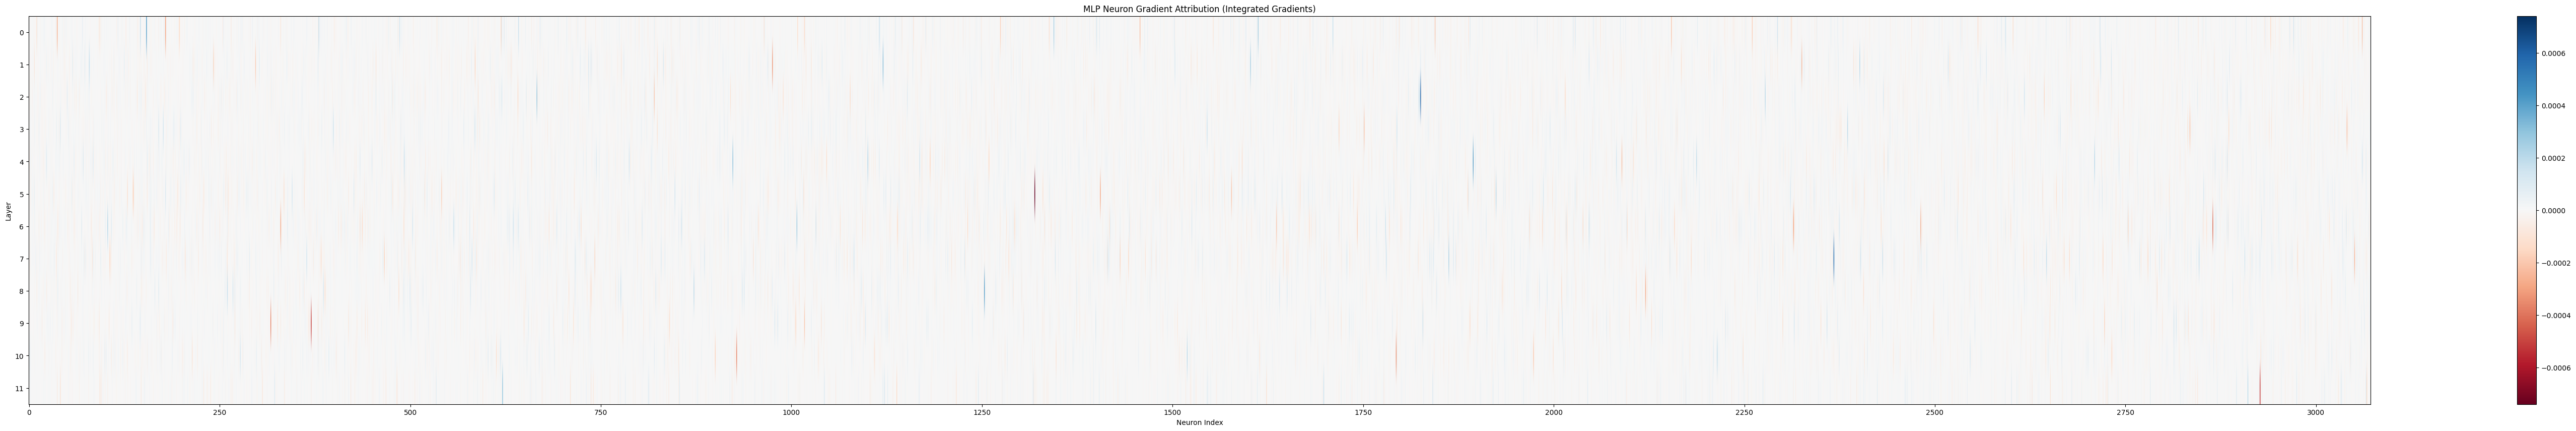

In [7]:
bound = max(torch.max(mlp_ig_zero_results), abs(torch.min(mlp_ig_zero_results)))

plt.figure(figsize=(75, 10))
plt.imshow(mlp_ig_zero_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound, aspect="auto")
plt.title("MLP Neuron Gradient Attribution (Integrated Gradients)")
plt.xticks(np.arange(0, model.cfg.d_mlp, 250))
plt.xlabel("Neuron Index")
plt.yticks(list(range(model.cfg.n_layers)))
plt.ylabel("Layer")
plt.colorbar()
plt.show()

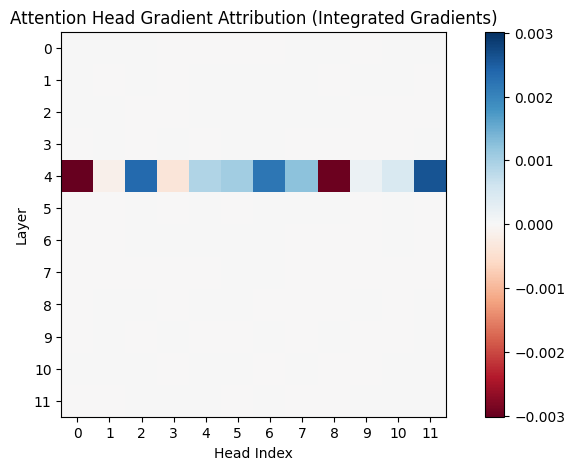

In [8]:
bound = max(torch.max(attn_ig_zero_results), abs(torch.min(attn_ig_zero_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_ig_zero_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Gradient Attribution (Integrated Gradients)")

plt.xlabel("Head Index")
plt.xticks(list(range(model.cfg.n_heads)))

plt.ylabel("Layer")
plt.yticks(list(range(model.cfg.n_layers)))

plt.colorbar()
plt.show()

## Activation Patching

In [5]:
def patch_neuron_hook(activations: torch.Tensor, hook: HookPoint, cache: ActivationCache, neuron_idx: int):
    # Replace the activations for the target neuron with activations from the cached run.
    cached_activations = cache[hook.name]
    activations[:, :, neuron_idx] = cached_activations[:, :, neuron_idx]
    return activations

def patch_attn_hook(activations: torch.Tensor, hook: HookPoint, cache: ActivationCache, head_idx: int):
    # Replace the activations for the target attention head with activations from the cached run.
    cached_activations = cache[hook.name]
    activations[:, :, head_idx, :] = cached_activations[:, :, head_idx, :]
    return activations

baseline_diff = (clean_logit_diff - corrupted_logit_diff).item()

In [6]:
mlp_patch_results = torch.load("mlp_patch_results.pt")
attn_patch_results = torch.load("attn_patch_results.pt")

In [ ]:
class StopExecution(Exception):
    def _render_traceback_(self):
        return []
    
# Check if we have run activation patching already (expensive)
try:
    mlp_patch_results = torch.load("mlp_patch_results.pt")
    attn_patch_results = torch.load("attn_patch_results.pt")
    raise StopExecution
except FileNotFoundError:
    mlp_patch_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
    attn_patch_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

    for layer in range(model.cfg.n_layers):
        # Activation patching on heads
        for head in range(model.cfg.n_heads):
            hook_name = get_act_name("result", layer)
            temp_hook = lambda act, hook: patch_attn_hook(act, hook, corrupted_cache, head)

            with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
                patched_logits = model(clean_input)

            patched_logit_diff = logits_to_logit_diff(patched_logits).detach()
            # Normalise result by clean and corrupted logit difference
            attn_patch_results[layer, head] = (patched_logit_diff - clean_logit_diff) / baseline_diff

        # Activation patching on MLP neurons
        for neuron in range(model.cfg.d_mlp):
            hook_name = get_act_name("post", layer)
            temp_hook = lambda act, hook: patch_neuron_hook(act, hook, corrupted_cache, neuron)
            
            with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
                patched_logits = model(clean_input)

            patched_logit_diff = logits_to_logit_diff(patched_logits).detach()
            # Normalise result by clean and corrupted logit difference
            mlp_patch_results[layer, neuron] = (patched_logit_diff - clean_logit_diff) / baseline_diff
    
    torch.save(mlp_patch_results, "mlp_patch_results.pt")
    torch.save(attn_patch_results, "attn_patch_results.pt")

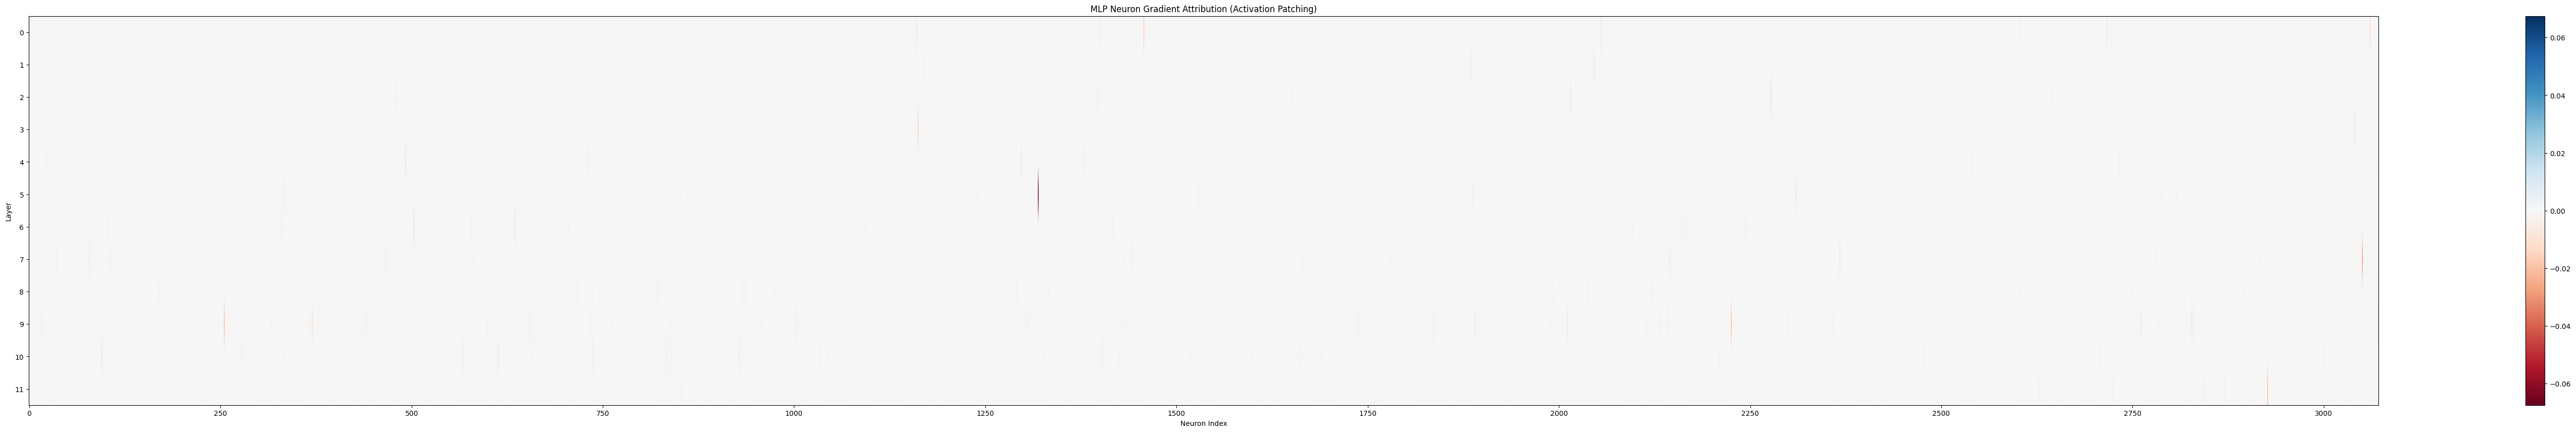

In [11]:
bound = max(torch.max(mlp_patch_results), abs(torch.min(mlp_patch_results)))

plt.figure(figsize=(75, 10))
plt.imshow(mlp_patch_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound, aspect="auto")
plt.title("MLP Neuron Gradient Attribution (Activation Patching)")
plt.xticks(np.arange(0, model.cfg.d_mlp, 250))
plt.xlabel("Neuron Index")
plt.yticks(list(range(model.cfg.n_layers)))
plt.ylabel("Layer")
plt.colorbar()
plt.show()

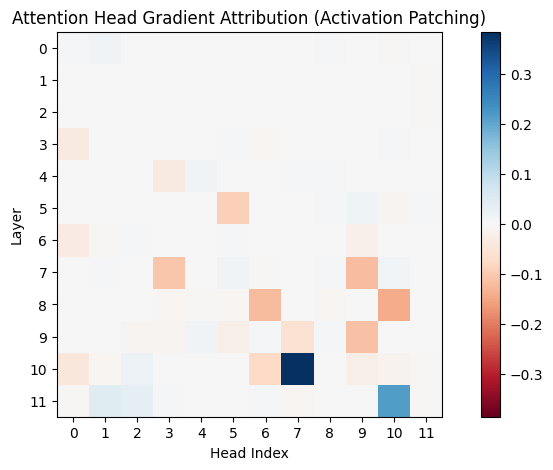

In [12]:
bound = max(torch.max(attn_patch_results), abs(torch.min(attn_patch_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_patch_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Gradient Attribution (Activation Patching)")

plt.xlabel("Head Index")
plt.xticks(list(range(model.cfg.n_heads)))

plt.ylabel("Layer")
plt.yticks(list(range(model.cfg.n_layers)))

plt.colorbar()
plt.show()

## Analysis of initial attribution methods

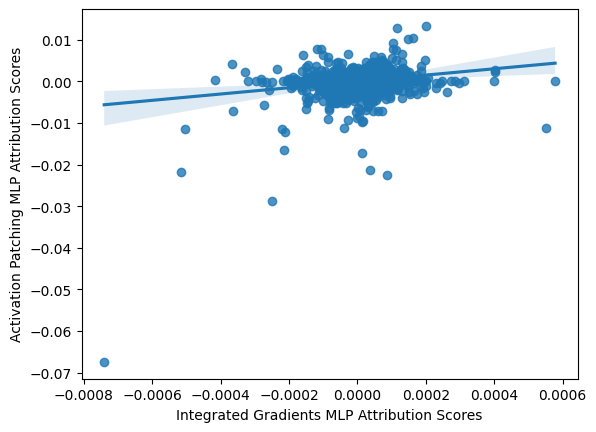

Correlation coefficient between IG and AP attributions for neurons: 0.2350942982779252


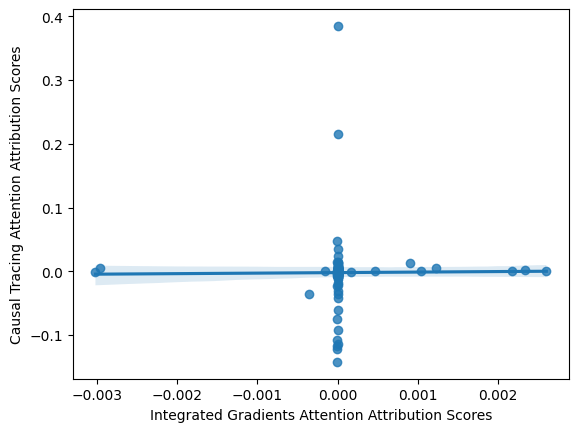

Correlation coefficient between IG and AP attributions for attention: 0.00930087754303134


In [13]:
# Plot the attribution scores against each other. Correlation: y = x.

x = mlp_ig_zero_results.flatten().numpy()
y = mlp_patch_results.flatten().numpy()

sns.regplot(x=x, y=y)
plt.xlabel("Integrated Gradients MLP Attribution Scores")
plt.ylabel("Activation Patching MLP Attribution Scores")
plt.show()

print(f"Correlation coefficient between IG and AP attributions for neurons: {np.corrcoef(x, y)[0, 1]}")

x = attn_ig_zero_results.flatten().numpy()
y = attn_patch_results.flatten().numpy()

sns.regplot(x=x, y=y)
plt.xlabel("Integrated Gradients Attention Attribution Scores")
plt.ylabel("Causal Tracing Attention Attribution Scores")
plt.show()

print(f"Correlation coefficient between IG and AP attributions for attention: {np.corrcoef(x, y)[0, 1]}")

In [14]:
def get_top_k_by_abs(data, k):
    _, indices = torch.topk(data.flatten().abs(), k)
    top_k_values = torch.gather(data.flatten(), 0, indices)
    formatted_indices = []
    for idx in indices:
        layer = idx // model.cfg.d_mlp
        neuron_pos = idx % model.cfg.d_mlp
        formatted_indices.append([layer, neuron_pos])
    return torch.tensor(formatted_indices), top_k_values

def get_attributions_above_threshold(data, percentile):
    threshold = torch.min(data) + percentile * (torch.max(data) - torch.min(data))
    masked_data = torch.where(data > threshold, data, 0)
    nonzero_indices = torch.nonzero(masked_data)
    return nonzero_indices, masked_data

top_mlp_ig_zero_indices, top_mlp_ig_zero_results = get_top_k_by_abs(mlp_ig_zero_results, 30)
top_mlp_patch_indices, top_mlp_patch_results = get_top_k_by_abs(mlp_patch_results, 30)

top_mlp_ig_zero_sets = set([tuple(t.tolist()) for t in top_mlp_ig_zero_indices])
top_mlp_patch_sets = set([tuple(t.tolist()) for t in top_mlp_patch_indices])

intersection = top_mlp_ig_zero_sets.intersection(top_mlp_patch_sets)
union = top_mlp_ig_zero_sets.union(top_mlp_patch_sets)
jaccard = len(intersection) / len(union)

print(f"Jaccard score for MLP neurons: {jaccard}")

Jaccard score for MLP neurons: 0.1111111111111111


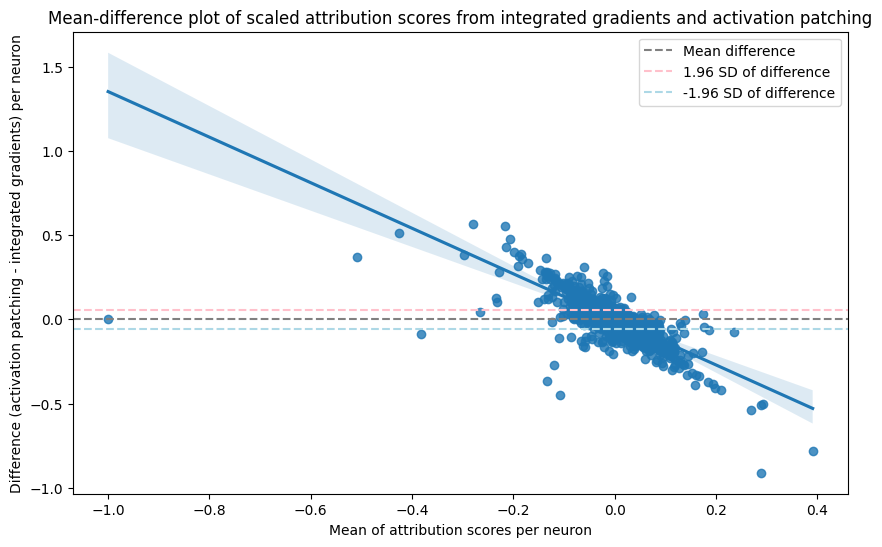

In [15]:
from sklearn.preprocessing import MaxAbsScaler

mlp_ig_zero_results_1d = mlp_ig_zero_results.flatten().numpy()
mlp_patch_results_1d = mlp_patch_results.flatten().numpy()

# Mean difference plot with scaled data

scaled_mlp_ig_results_1d = MaxAbsScaler().fit_transform(mlp_ig_zero_results_1d.reshape(-1, 1))
scaled_mlp_patch_results_1d = MaxAbsScaler().fit_transform(mlp_patch_results_1d.reshape(-1, 1))

mean = np.mean([scaled_mlp_ig_results_1d, scaled_mlp_patch_results_1d], axis=0)
diff = scaled_mlp_patch_results_1d - scaled_mlp_ig_results_1d
md = np.mean(diff) # Mean of the difference
sd = np.std(diff, axis=0) # Standard deviation of the difference

plt.figure(figsize=(10, 6))
sns.regplot(x=mean, y=diff, fit_reg=True, scatter=True)
plt.axhline(md, color='gray', linestyle='--', label="Mean difference")
plt.axhline(md + 1.96*sd, color='pink', linestyle='--', label="1.96 SD of difference")
plt.axhline(md - 1.96*sd, color='lightblue', linestyle='--', label="-1.96 SD of difference")
plt.xlabel("Mean of attribution scores per neuron")
plt.ylabel("Difference (activation patching - integrated gradients) per neuron")
plt.title("Mean-difference plot of scaled attribution scores from integrated gradients and activation patching")
plt.legend()
plt.show()

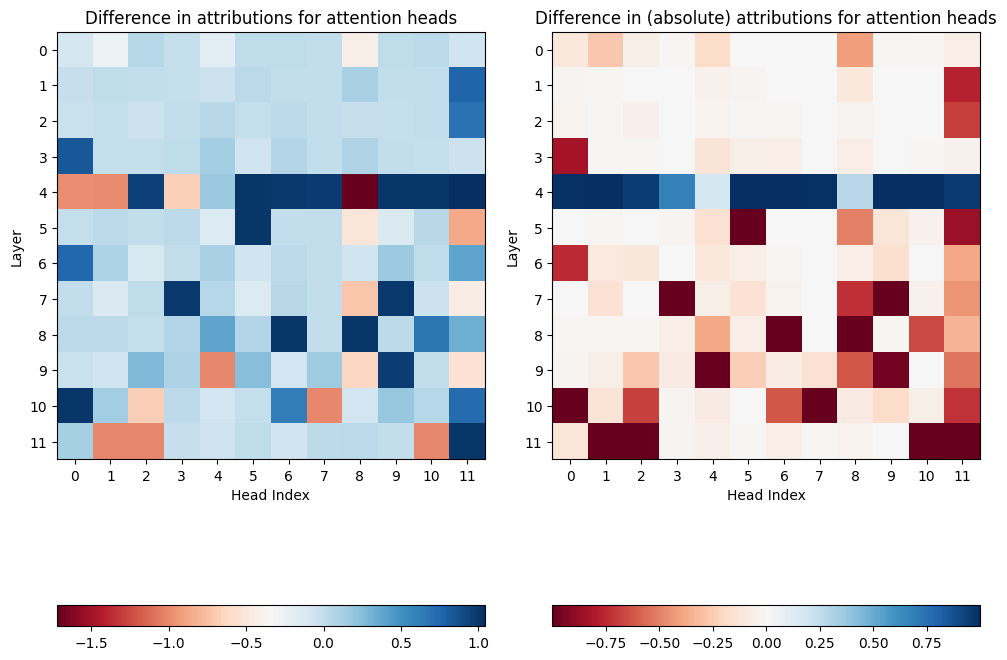

In [26]:
from sklearn.preprocessing import MaxAbsScaler

scaled_attn_ig_zero_results = MaxAbsScaler().fit_transform(attn_ig_zero_results)
scaled_attn_patch_results = MaxAbsScaler().fit_transform(attn_patch_results)

diff_attn_results = scaled_attn_ig_zero_results - scaled_attn_patch_results
diff_attn_results_abs = np.abs(scaled_attn_ig_zero_results) - np.abs(scaled_attn_patch_results)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(diff_attn_results, cmap="RdBu")
plt.title("Difference in attributions for attention heads")

plt.xlabel("Head Index")
plt.xticks(list(range(model.cfg.n_heads)))

plt.ylabel("Layer")
plt.yticks(list(range(model.cfg.n_layers)))

plt.colorbar(orientation="horizontal")

plt.subplot(1, 2, 2)
plt.imshow(diff_attn_results_abs, cmap="RdBu")
plt.title("Difference in (absolute) attributions for attention heads")

plt.xlabel("Head Index")
plt.xticks(list(range(model.cfg.n_heads)))

plt.ylabel("Layer")
plt.yticks(list(range(model.cfg.n_layers)))

plt.colorbar(orientation="horizontal")
plt.tight_layout()
plt.show()

# Comparable baselines

*Hypothesis*: One possible reason for the discrepancy between patching and IG is that the range of activations tested may be from different distributions.

Both gradient methods rely on counterfactual reasoning. IG computes the integral between some baseline (which produces zero output) and given input, whereas causal tracing computes the logit difference between two counterfactual inputs. If the counterfactuals used are different, then this could cause a discrepancy.

To evaluate this hypothesis, we compute IG and AP on GPT2-Small with the same counterfactual inputs.

In [7]:
mlp_ig_results = torch.load("mlp_ig_results.pt")
attn_ig_results = torch.load("attn_ig_results.pt")

In [ ]:
# Gradient attribution for neurons in MLP layers
mlp_ig_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
# Gradient attribution for attention heads
attn_ig_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

# Calculate integrated gradients for each layer
for layer in range(model.cfg.n_layers):
    # Gradient attribution on heads
    hook_name = get_act_name("result", layer)
    target_layer = model.hook_dict[hook_name]
    prev_layer_hook = get_act_name("z", layer)
    prev_layer = model.hook_dict[prev_layer_hook]

    layer_clean_input = clean_cache[prev_layer_hook]
    layer_corrupt_input = corrupted_cache[prev_layer_hook]

    attributions = compute_layer_to_output_attributions(clean_input, layer_corrupt_input, layer_clean_input, target_layer, prev_layer) # shape [1, seq_len, d_head, d_model]
    # Calculate attribution score based on mean over each embedding, for each token
    print(attributions.shape)
    per_token_score = attributions.mean(dim=3)
    score = per_token_score.mean(dim=1)
    attn_ig_results[layer] = score

    # Gradient attribution on MLP neurons
    hook_name = get_act_name("post", layer)
    target_layer = model.hook_dict[hook_name]
    prev_layer_hook = get_act_name("mlp_in", layer)
    prev_layer = model.hook_dict[prev_layer_hook]

    layer_clean_input = clean_cache[prev_layer_hook]
    layer_corrupt_input = corrupted_cache[prev_layer_hook]
    
    attributions = compute_layer_to_output_attributions(clean_input, layer_corrupt_input, layer_clean_input, target_layer, prev_layer) # shape [1, seq_len, d_model]
    print(attributions.shape)
    score = attributions.mean(dim=1)
    mlp_ig_results[layer] = score

torch.save(mlp_ig_results, "mlp_ig_results.pt")
torch.save(attn_ig_results, "attn_ig_results.pt")


Error (delta) for blocks.0.attn.hook_result attribution: -0.08010423183441162
torch.Size([1, 17, 12, 768])

Error (delta) for blocks.0.mlp.hook_post attribution: 5.367663860321045
torch.Size([1, 17, 3072])

Error (delta) for blocks.1.attn.hook_result attribution: 0.05616430938243866
torch.Size([1, 17, 12, 768])

Error (delta) for blocks.1.mlp.hook_post attribution: -0.10697655379772186
torch.Size([1, 17, 3072])

Error (delta) for blocks.2.attn.hook_result attribution: -0.012761879712343216
torch.Size([1, 17, 12, 768])

Error (delta) for blocks.2.mlp.hook_post attribution: -0.11945552378892899
torch.Size([1, 17, 3072])

Error (delta) for blocks.3.attn.hook_result attribution: 0.2565889358520508
torch.Size([1, 17, 12, 768])

Error (delta) for blocks.3.mlp.hook_post attribution: 0.1360594630241394
torch.Size([1, 17, 3072])

Error (delta) for blocks.4.attn.hook_result attribution: 0.051070213317871094
torch.Size([1, 17, 12, 768])

Error (delta) for blocks.4.mlp.hook_post attribution: -0.0

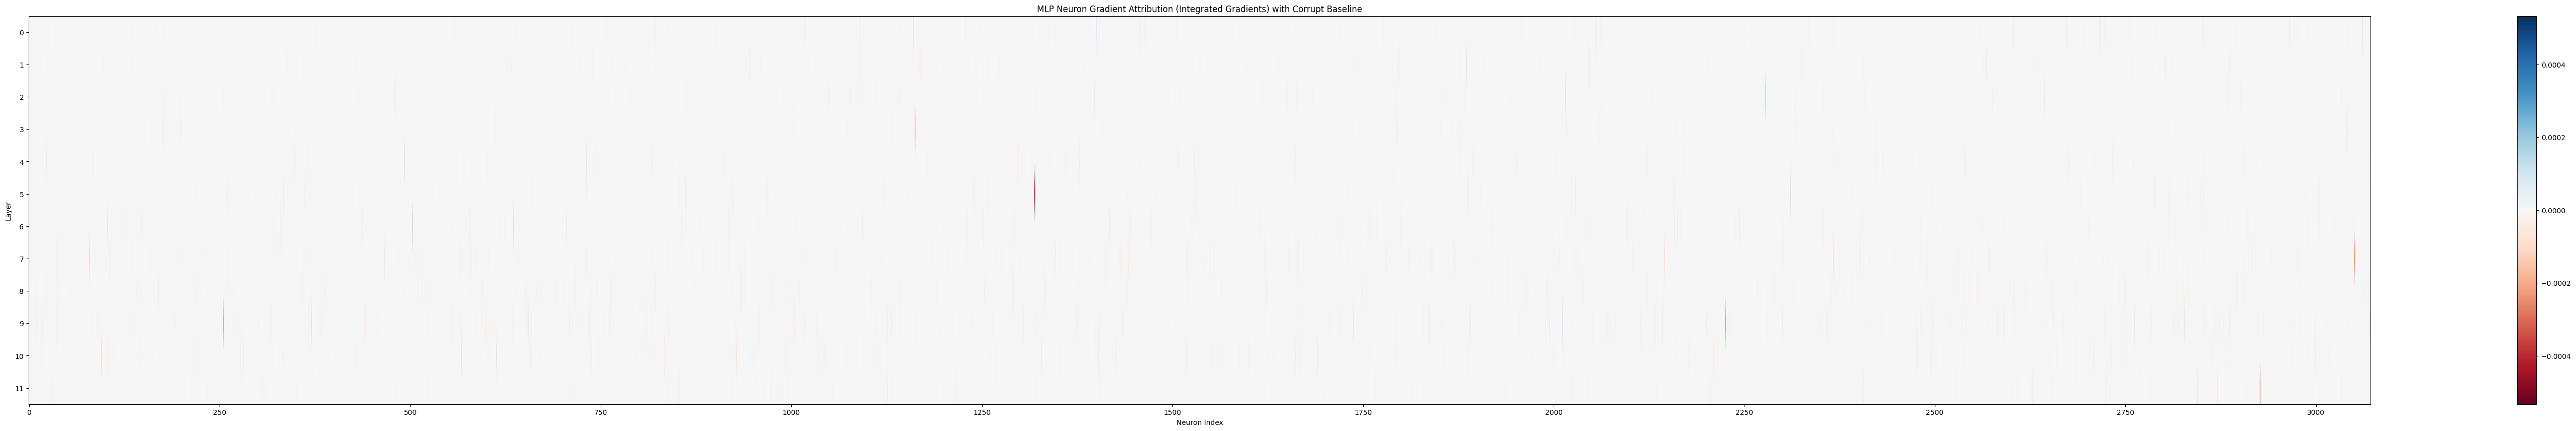

In [35]:
bound = max(torch.max(mlp_ig_results), abs(torch.min(mlp_ig_results)))

plt.figure(figsize=(75, 10))
plt.imshow(mlp_ig_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound, aspect="auto")
plt.title("MLP Neuron Gradient Attribution (Integrated Gradients) with Corrupt Baseline")
plt.xticks(np.arange(0, model.cfg.d_mlp, 250))
plt.xlabel("Neuron Index")
plt.yticks(list(range(model.cfg.n_layers)))
plt.ylabel("Layer")
plt.colorbar()
plt.show()

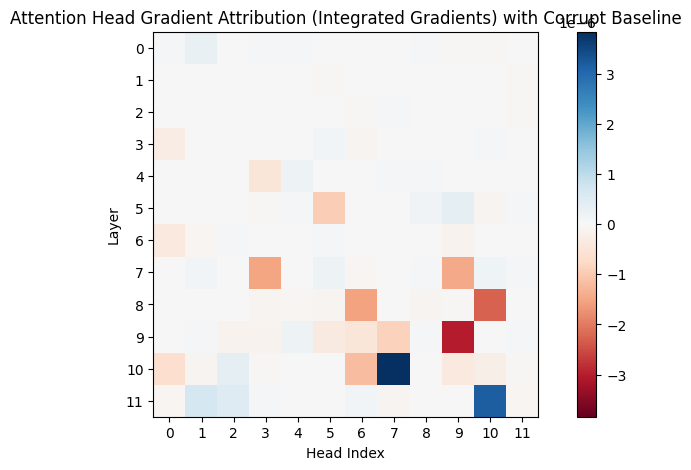

In [38]:
bound = max(torch.max(attn_ig_results), abs(torch.min(attn_ig_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_ig_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Gradient Attribution (Integrated Gradients) with Corrupt Baseline")

plt.xlabel("Head Index")
plt.xticks(list(range(model.cfg.n_heads)))

plt.ylabel("Layer")
plt.yticks(list(range(model.cfg.n_layers)))

plt.colorbar()
plt.show()

## Analysis of comparable baselines

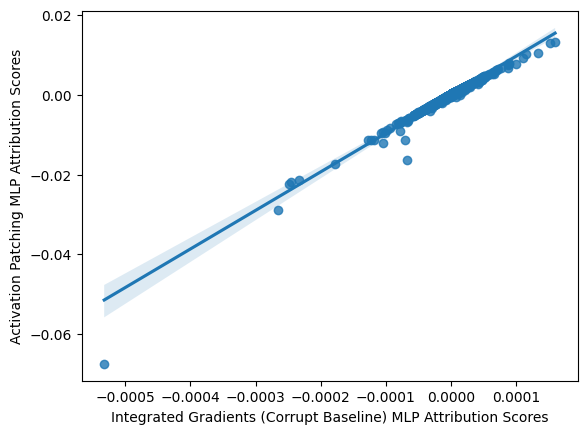

Correlation coefficient between IG with corrupted baseline and AP attributions for neurons: 0.9852227509307566


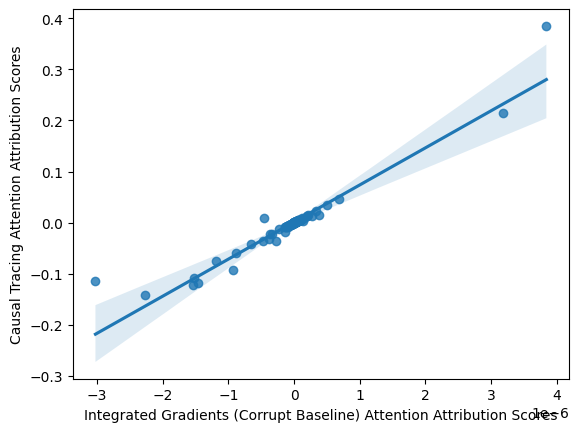

Correlation coefficient between IG with corrupted baseline and AP attributions for attention: 0.9547628738711134


In [42]:
# Plot the attribution scores against each other. Correlation: y = x.

x = mlp_ig_results.flatten().numpy()
y = mlp_patch_results.flatten().numpy()

sns.regplot(x=x, y=y)
plt.xlabel("Integrated Gradients (Corrupt Baseline) MLP Attribution Scores")
plt.ylabel("Activation Patching MLP Attribution Scores")
plt.show()

print(f"Correlation coefficient between IG with corrupted baseline and AP attributions for neurons: {np.corrcoef(x, y)[0, 1]}")

x = attn_ig_results.flatten().numpy()
y = attn_patch_results.flatten().numpy()

sns.regplot(x=x, y=y)
plt.xlabel("Integrated Gradients (Corrupt Baseline) Attention Attribution Scores")
plt.ylabel("Causal Tracing Attention Attribution Scores")
plt.show()

print(f"Correlation coefficient between IG with corrupted baseline and AP attributions for attention: {np.corrcoef(x, y)[0, 1]}")

The correlation between attribution scores for MLP neurons and attention heads is extremely high! This indicates that, with the same baseline, both methods obtain very similar attribution scores.

In [20]:
def get_top_k_by_abs(data, k):
    _, indices = torch.topk(data.flatten().abs(), k)
    top_k_values = torch.gather(data.flatten(), 0, indices)
    formatted_indices = []
    for idx in indices:
        layer = idx // model.cfg.d_mlp
        neuron_pos = idx % model.cfg.d_mlp
        formatted_indices.append([layer, neuron_pos])
    return torch.tensor(formatted_indices), top_k_values

def get_attributions_above_threshold(data, percentile):
    threshold = torch.min(data) + percentile * (torch.max(data) - torch.min(data))
    masked_data = torch.where(data > threshold, data, 0)
    nonzero_indices = torch.nonzero(masked_data)
    return nonzero_indices, masked_data

top_mlp_ig_indices, top_mlp_ig_results = get_top_k_by_abs(mlp_ig_results, 30)
top_mlp_patch_indices, top_mlp_patch_results = get_top_k_by_abs(mlp_patch_results, 30)

top_mlp_ig_sets = set([tuple(t.tolist()) for t in top_mlp_ig_indices])
top_mlp_patch_sets = set([tuple(t.tolist()) for t in top_mlp_patch_indices])

intersection = top_mlp_ig_sets.intersection(top_mlp_patch_sets)
union = top_mlp_ig_sets.union(top_mlp_patch_sets)
jaccard = len(intersection) / len(union)

print(f"Jaccard score for MLP neurons: {jaccard}")

Jaccard score for MLP neurons: 0.875


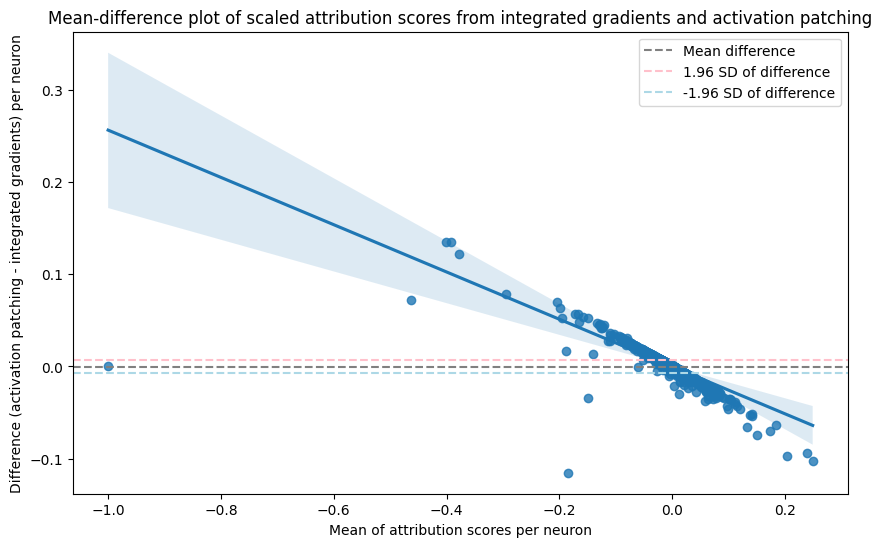

In [40]:
from sklearn.preprocessing import MaxAbsScaler

mlp_ig_results_1d = mlp_ig_results.flatten().numpy()
mlp_patch_results_1d = mlp_patch_results.flatten().numpy()

# Mean difference plot with scaled data

scaled_mlp_ig_results_1d = MaxAbsScaler().fit_transform(mlp_ig_results_1d.reshape(-1, 1))
scaled_mlp_patch_results_1d = MaxAbsScaler().fit_transform(mlp_patch_results_1d.reshape(-1, 1))

mean = np.mean([scaled_mlp_ig_results_1d, scaled_mlp_patch_results_1d], axis=0)
diff = scaled_mlp_patch_results_1d - scaled_mlp_ig_results_1d
md = np.mean(diff) # Mean of the difference
sd = np.std(diff, axis=0) # Standard deviation of the difference

plt.figure(figsize=(10, 6))
sns.regplot(x=mean, y=diff, fit_reg=True, scatter=True)
plt.axhline(md, color='gray', linestyle='--', label="Mean difference")
plt.axhline(md + 1.96*sd, color='pink', linestyle='--', label="1.96 SD of difference")
plt.axhline(md - 1.96*sd, color='lightblue', linestyle='--', label="-1.96 SD of difference")
plt.xlabel("Mean of attribution scores per neuron")
plt.ylabel("Difference (activation patching - integrated gradients) per neuron")
plt.title("Mean-difference plot of scaled attribution scores from integrated gradients and activation patching")
plt.legend()
plt.show()

The mean difference plot seems to suggest that there is still some proportional bias. The difference between activation patching scores and integrated gradients scores increases as the attribution score deviates from 0.  Integrated gradients seems to estimate more extreme attribution scores than activation patching.

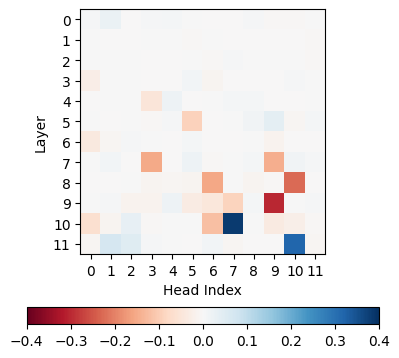

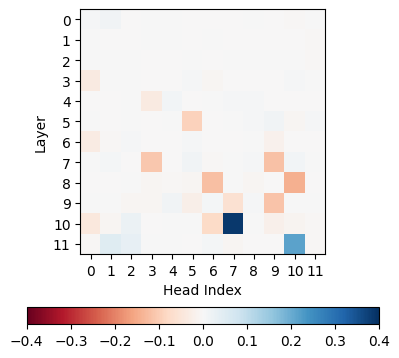

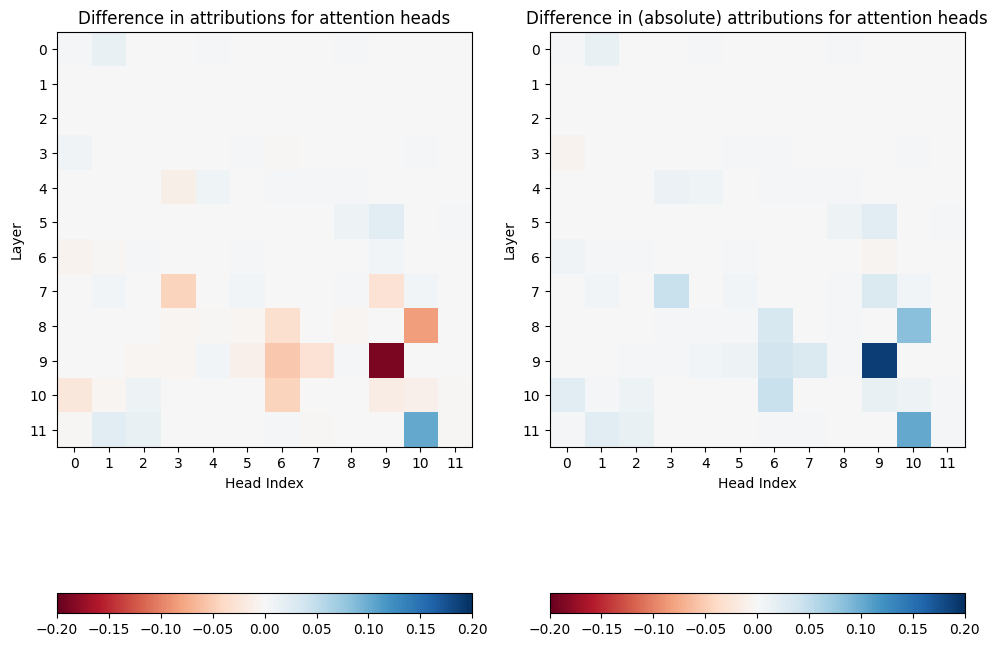

In [8]:
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler, RobustScaler

scaled_attn_ig_results = attn_ig_results * 1e5
scaled_attn_patch_results = attn_patch_results

plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.imshow(scaled_attn_ig_results, cmap="RdBu", vmin=-0.4, vmax=0.4)
plt.xlabel("Head Index")
plt.xticks(list(range(model.cfg.n_heads)))
plt.ylabel("Layer")
plt.yticks(list(range(model.cfg.n_layers)))
plt.colorbar(orientation="horizontal")

plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.imshow(scaled_attn_patch_results, cmap="RdBu", vmin=-0.4, vmax=0.4)
plt.xlabel("Head Index")
plt.xticks(list(range(model.cfg.n_heads)))
plt.ylabel("Layer")
plt.yticks(list(range(model.cfg.n_layers)))
plt.colorbar(orientation="horizontal")

diff_attn_results = scaled_attn_ig_results - scaled_attn_patch_results
diff_attn_results_abs = np.abs(scaled_attn_ig_results) - np.abs(scaled_attn_patch_results)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(diff_attn_results, cmap="RdBu", vmin=-0.2, vmax=0.2)
plt.title("Difference in attributions for attention heads")

plt.xlabel("Head Index")
plt.xticks(list(range(model.cfg.n_heads)))

plt.ylabel("Layer")
plt.yticks(list(range(model.cfg.n_layers)))

plt.colorbar(orientation="horizontal")

plt.subplot(1, 2, 2)
plt.imshow(diff_attn_results_abs, cmap="RdBu", vmin=-0.2, vmax=0.2)
plt.title("Difference in (absolute) attributions for attention heads")

plt.xlabel("Head Index")
plt.xticks(list(range(model.cfg.n_heads)))

plt.ylabel("Layer")
plt.yticks(list(range(model.cfg.n_layers)))

plt.colorbar(orientation="horizontal")
plt.tight_layout()
plt.show()

Remaining questions include:

- Although both methods are aligned when the baselines are the same, this doesn't mean that they capture the most faithful attribution scores. For instance, if we change the baseline (which is arbitrarily set to some counterfactual value), we could get different components in the circuit. **How do we select the best baselines such that faithful circuits are highlighted?**

- There are still some discrepancies in attribution scores, particularly for attention heads. **What could be the cause of different attention head attribution scores?**



# Comparison to IOI circuit

The attention heads highlighted in the original IOI paper seem to correspond with the attention heads highlighted by both methods.

![ioi_diagram](reference/ioi_diagram.png)

# Investigation of discrepancies

## General-purpose components

*Hypothesis*: the components which are highlighted more strongly by integrated gradients are important attention heads, which are used generically in both the clean run and corrupted run.

- They are not detected as strongly by activation patching, which only takes the difference in logits, i.e. highlights components which are needed for the corrupted run, but not the clean run.

In [9]:
import json

class IOIDataset:

    def __init__(self, src_path: str):
        with open(src_path) as f:
            self.data = json.load(f)
        
    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            prompts_answers = [(d['prompt'], d['answer']) for d in self.data[idx]]
            return prompts_answers
        return (self.data[idx]['prompt'], self.data[idx]['answer'])

    def to(self, device):
        self.data = self.data.to(device)
        return self


In [10]:
ioi_dataset = IOIDataset("ioi_dataset.json")[:10_000]

### Experiment 1: zero ablation

To test this, we can ablate the components which have statistically significant attribution scores outside the limits of agreement. If they affect the performance, this shows that the components are necessary, even though they are not picked up by activation patching.

In [11]:
def evaluate_ioi_performance(ioi_dataset: IOIDataset, model: HookedTransformer):
    num_correct = 0
    num_eval = 0
    for prompt, answer in ioi_dataset:
        if num_eval % 50 == 0:
            print(f"Evaluating prompt {num_eval}")
        outputs = model.generate(input=prompt, max_new_tokens=3, do_sample=False, verbose=False)
        generated_answer = outputs.removeprefix(prompt).split()[0]
        if answer in generated_answer:
            num_correct += 1
        num_eval += 1
    return num_correct / num_eval


In [ ]:
# Measure baseline performance of model on IOI task
baseline_performance = evaluate_ioi_performance(ioi_dataset, model)
print(baseline_performance)

Moving model to device:  cpu
Evaluating prompt 0
Evaluating prompt 50
Evaluating prompt 100
Evaluating prompt 150
Evaluating prompt 200
Evaluating prompt 250
Evaluating prompt 300
Evaluating prompt 350
Evaluating prompt 400
Evaluating prompt 450
Evaluating prompt 500
Evaluating prompt 550
Evaluating prompt 600
Evaluating prompt 650
Evaluating prompt 700
Evaluating prompt 750
Evaluating prompt 800
Evaluating prompt 850
Evaluating prompt 900
Evaluating prompt 950
Evaluating prompt 1000
Evaluating prompt 1050
Evaluating prompt 1100
Evaluating prompt 1150
Evaluating prompt 1200
Evaluating prompt 1250
Evaluating prompt 1300
Evaluating prompt 1350
Evaluating prompt 1400
Evaluating prompt 1450
Evaluating prompt 1500
Evaluating prompt 1550
Evaluating prompt 1600
Evaluating prompt 1650
Evaluating prompt 1700
Evaluating prompt 1750
Evaluating prompt 1800
Evaluating prompt 1850
Evaluating prompt 1900
Evaluating prompt 1950
Evaluating prompt 2000
Evaluating prompt 2050
Evaluating prompt 2100
Evalu

In [12]:
# Identify statistically significant outlier components

diff = np.abs(scaled_attn_patch_results - scaled_attn_ig_results)
diff_std = np.std(diff.numpy())

print(f"Standard deviation of differences: {diff_std}")

attn_outliers = []
for layer in range(model.cfg.n_layers):
    for head_idx in range(model.cfg.n_heads):
        if diff[layer, head_idx] > 1.96*diff_std:
            attn_outliers.append((layer, head_idx))

print(attn_outliers)

Standard deviation of differences: 0.020343296229839325
[(7, 3), (8, 10), (9, 6), (9, 9), (10, 6), (11, 10)]


In [178]:
# Ablate components: zero ablation

all_performance_scores = []

for layer, head_idx in attn_outliers:
    attn_hook = get_act_name("result", layer)

    def ablate_hook(activations, hook):
        activations[:, :, head_idx, :] = 0
        return activations

    with model.hooks(fwd_hooks=[(attn_hook, ablate_hook)]):
        performance = evaluate_ioi_performance(ioi_dataset, model)
        all_performance_scores.append(performance)
        print(f"Performance after ablating attention head {(layer, head_idx)}: {performance}")

# TODO: Mean ablation, random ablation

Evaluating prompt 0
Evaluating prompt 50
Evaluating prompt 100
Evaluating prompt 150
Evaluating prompt 200
Evaluating prompt 250
Evaluating prompt 300
Evaluating prompt 350
Evaluating prompt 400
Evaluating prompt 450
Evaluating prompt 500
Evaluating prompt 550
Evaluating prompt 600
Evaluating prompt 650
Evaluating prompt 700
Evaluating prompt 750
Evaluating prompt 800
Evaluating prompt 850
Evaluating prompt 900
Evaluating prompt 950
Evaluating prompt 1000
Evaluating prompt 1050
Evaluating prompt 1100
Evaluating prompt 1150
Evaluating prompt 1200
Evaluating prompt 1250
Evaluating prompt 1300
Evaluating prompt 1350
Evaluating prompt 1400
Evaluating prompt 1450
Evaluating prompt 1500
Evaluating prompt 1550
Evaluating prompt 1600
Evaluating prompt 1650
Evaluating prompt 1700
Evaluating prompt 1750
Evaluating prompt 1800
Evaluating prompt 1850
Evaluating prompt 1900
Evaluating prompt 1950
Evaluating prompt 2000
Evaluating prompt 2050
Evaluating prompt 2100
Evaluating prompt 2150
Evaluating 

In [181]:
print(baseline_performance)
print(all_performance_scores)

0.7864
[0.6981, 0.7877, 0.8052, 0.8009, 0.7245, 0.9361]


In [180]:
np.save("all_performance_scores.npy", all_performance_scores)

In [182]:
for layer, idx in attn_outliers:
    print(f"Attention head {(layer, idx)}")
    ig_score = attn_ig_results[layer, idx]
    patch_score = attn_patch_results[layer, idx]
    print(f"IG score: {ig_score:.5f}, AP score: {patch_score:.5f}\n")

Attention head (7, 3)
IG score: -0.00000, AP score: -0.10789

Attention head (8, 10)
IG score: -0.00000, AP score: -0.14233

Attention head (9, 6)
IG score: -0.00000, AP score: 0.00889

Attention head (9, 9)
IG score: -0.00000, AP score: -0.11382

Attention head (10, 6)
IG score: -0.00000, AP score: -0.07559

Attention head (11, 10)
IG score: 0.00000, AP score: 0.21538



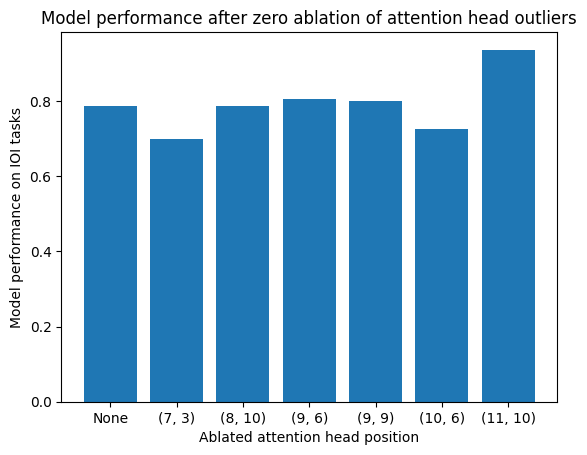

In [183]:
plt.title("Model performance after zero ablation of attention head outliers")
plt.xlabel("Ablated attention head position")
plt.ylabel("Model performance on IOI tasks")

xs = ["None"] + [str(t) for t in attn_outliers]
ys = [baseline_performance] + all_performance_scores

plt.bar(xs, ys)
plt.show()

In [184]:
# Correlation between difference in attribution scores and difference in performance

performance_differences = []
ig_outlier_scores = []
ap_outlier_scores = []
score_differences = []

for i in range(len(all_performance_scores)):
    performance_differences.append(all_performance_scores[i] - baseline_performance)
    layer, attn_idx = attn_outliers[i]
    ap_outlier_scores.append(attn_patch_results[layer, attn_idx])
    ig_outlier_scores.append(attn_ig_results[layer, attn_idx])
    score_diff = attn_patch_results[layer, attn_idx] - attn_ig_results[layer, attn_idx]
    score_differences.append(score_diff)

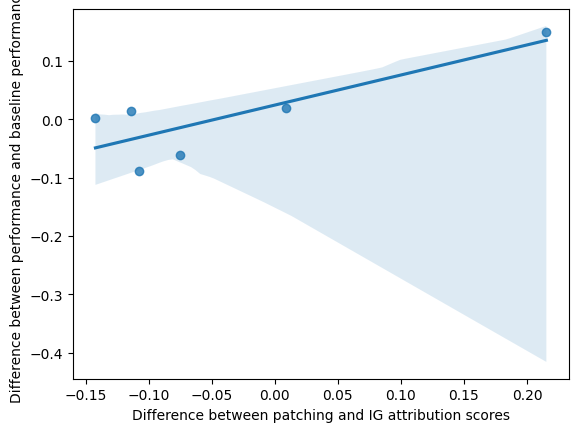

Correlation coefficient between attribution score differences and performance score differences: 0.8298786622776018


In [185]:
sns.regplot(x=score_differences, y=performance_differences)
plt.ylabel("Difference between performance and baseline performance")
plt.xlabel("Difference between patching and IG attribution scores")
plt.show()

print(f"Correlation coefficient between attribution score differences and performance score differences: {np.corrcoef(score_differences, performance_differences)[0, 1]}")

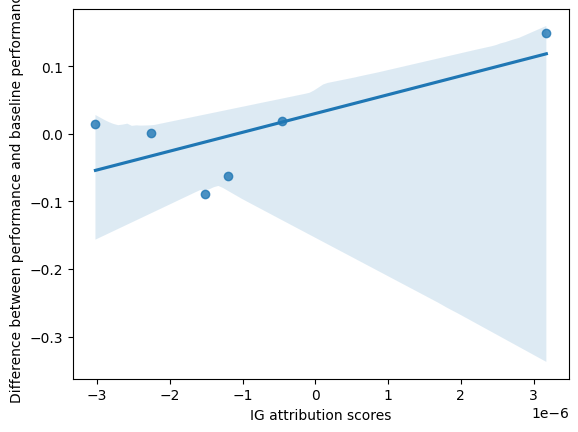

Correlation coefficient between IG attribution score and performance score differences: 0.7296915879554248


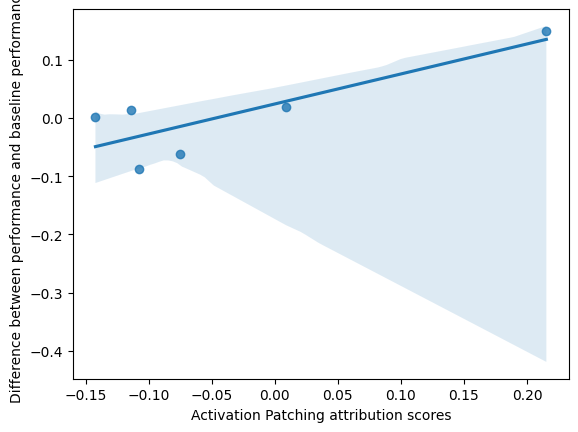

Correlation coefficient between IG attribution score and performance score differences: 0.8298774188113335


In [186]:
# Correlation between attribution scores and performance change

sns.regplot(x=ig_outlier_scores, y=performance_differences)
plt.ylabel("Difference between performance and baseline performance")
plt.xlabel("IG attribution scores")
plt.show()

print(f"Correlation coefficient between IG attribution score and performance score differences: {np.corrcoef(ig_outlier_scores, performance_differences)[0, 1]}")

sns.regplot(x=ap_outlier_scores, y=performance_differences)
plt.ylabel("Difference between performance and baseline performance")
plt.xlabel("Activation Patching attribution scores")
plt.show()

print(f"Correlation coefficient between IG attribution score and performance score differences: {np.corrcoef(ap_outlier_scores, performance_differences)[0, 1]}")

Of all the outliers, head (9, 6) is the only one which is strongly highlighted by integrated gradients, but not by activation patching. The other outliers have larger attribution scores assigned by integrated gradients compared to activation patching, but are highlighted by both methods.

- Ablating head (9, 6) does not have a strong effect on the performance. 
    - *Conclusion*: components which are only identified by integrated gradients may not be important for the specific task.
- Interestingly, ablating heads identified as moderately important by activation patching (e.g. (8, 10), (9, 6), and (9, 9)) do not have significant impact on the performance either. 
    - *Conclusion*: neither method identifies the minimal set of important attention heads.
    - Comparison to original IOI paper: under mean ablation, these heads (and 9.6) are highlighted and impact performance more noticeably.
- There is not really a strong pattern / correlation between components which have higher attribution scores under IG or AP, and impact on performance.

### Experiment 2: Mean ablation

Instead of using zero ablation, we use mean ablation to study the effect of a component's removal on the model's performance.

In [16]:
import random

# Get mean activations
model = model.to("cpu")

attn_outlier_hooks = [get_act_name("result", layer_idx) for layer_idx, _ in attn_outliers]

random_prompts = random.sample(ioi_dataset, 100)
prompts_tokens = model.to_tokens([p for p, _ in random_prompts])
_, prompt_cache = model.run_with_cache(prompts_tokens, names_filter=lambda x: x in attn_outlier_hooks)

mean_activations = {}
for key in prompt_cache.keys():
    mean_values_over_prompts = torch.mean(prompt_cache[key], dim=0)
    mean_activations[key] = torch.mean(mean_values_over_prompts, dim=0)

Moving model to device:  cpu


In [18]:
# Ablate components: mean ablation

all_performance_scores_mean_ablation = []

for layer, head_idx in attn_outliers:
    attn_hook = get_act_name("result", layer)

    def ablate_hook(activations, hook):
        mean_hook_acts = mean_activations[hook.name]
        activations[:, :, head_idx, :] = mean_hook_acts[head_idx]
        return activations

    with model.hooks(fwd_hooks=[(attn_hook, ablate_hook)]):
        performance = evaluate_ioi_performance(ioi_dataset, model)
        all_performance_scores_mean_ablation.append(performance)
        print(f"Performance after mean ablating attention head {(layer, head_idx)}: {performance}")

Evaluating prompt 0
Evaluating prompt 50
Evaluating prompt 100
Evaluating prompt 150
Evaluating prompt 200
Evaluating prompt 250
Evaluating prompt 300
Evaluating prompt 350
Evaluating prompt 400
Evaluating prompt 450
Evaluating prompt 500
Evaluating prompt 550
Evaluating prompt 600
Evaluating prompt 650
Evaluating prompt 700
Evaluating prompt 750
Evaluating prompt 800
Evaluating prompt 850
Evaluating prompt 900
Evaluating prompt 950
Evaluating prompt 1000
Evaluating prompt 1050
Evaluating prompt 1100
Evaluating prompt 1150
Evaluating prompt 1200
Evaluating prompt 1250
Evaluating prompt 1300
Evaluating prompt 1350
Evaluating prompt 1400
Evaluating prompt 1450
Evaluating prompt 1500
Evaluating prompt 1550
Evaluating prompt 1600
Evaluating prompt 1650
Evaluating prompt 1700
Evaluating prompt 1750
Evaluating prompt 1800
Evaluating prompt 1850
Evaluating prompt 1900
Evaluating prompt 1950
Evaluating prompt 2000
Evaluating prompt 2050
Evaluating prompt 2100
Evaluating prompt 2150
Evaluating 

In [21]:
print(all_performance_scores_mean_ablation)

np.save("all_performance_scores_mean_ablation.npy", all_performance_scores_mean_ablation)

[0.712, 0.7912, 0.8386, 0.7772, 0.7141, 0.9436]


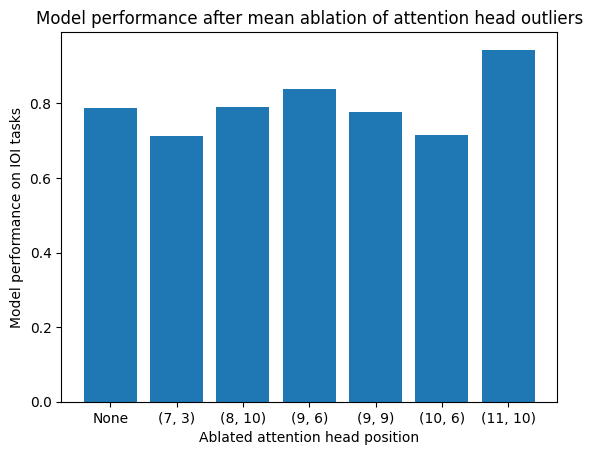

In [23]:
plt.title("Model performance after mean ablation of attention head outliers")
plt.xlabel("Ablated attention head position")
plt.ylabel("Model performance on IOI tasks")

xs = ["None"] + [str(t) for t in attn_outliers]
baseline_performance = 0.7864
ys = [baseline_performance] + all_performance_scores_mean_ablation

plt.bar(xs, ys)
plt.show()

In [24]:
# Correlation between difference in attribution scores and difference in performance

mean_performance_differences = []
ig_outlier_scores = []
ap_outlier_scores = []
score_differences = []

for i in range(len(all_performance_scores_mean_ablation)):
    mean_performance_differences.append(all_performance_scores_mean_ablation[i] - baseline_performance)
    layer, attn_idx = attn_outliers[i]
    ap_outlier_scores.append(attn_patch_results[layer, attn_idx])
    ig_outlier_scores.append(attn_ig_results[layer, attn_idx])
    score_diff = attn_patch_results[layer, attn_idx] - attn_ig_results[layer, attn_idx]
    score_differences.append(score_diff)

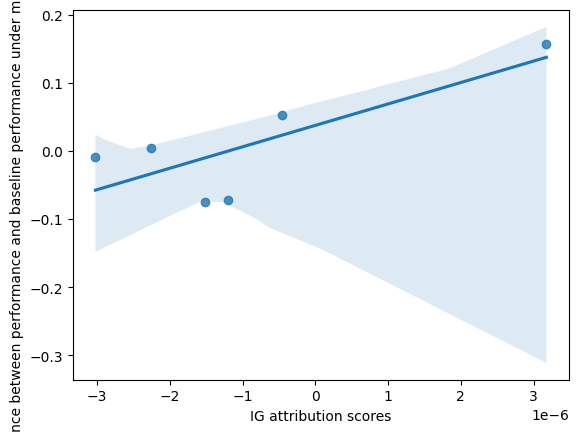

Correlation coefficient between IG attribution score and performance score difference under mean ablation: 0.7868078399469188


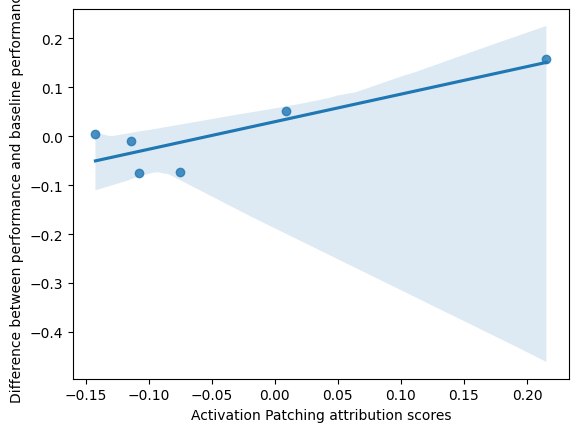

Correlation coefficient between IG attribution score and performance score difference under mean ablation: 0.8659126942995752


In [25]:
# Correlation between attribution scores and performance change

sns.regplot(x=ig_outlier_scores, y=mean_performance_differences)
plt.ylabel("Difference between performance and baseline performance under mean ablation")
plt.xlabel("IG attribution scores")
plt.show()

print(f"Correlation coefficient between IG attribution score and performance score difference under mean ablation: {np.corrcoef(ig_outlier_scores, mean_performance_differences)[0, 1]}")

sns.regplot(x=ap_outlier_scores, y=mean_performance_differences)
plt.ylabel("Difference between performance and baseline performance")
plt.xlabel("Activation Patching attribution scores")
plt.show()

print(f"Correlation coefficient between IG attribution score and performance score difference under mean ablation: {np.corrcoef(ap_outlier_scores, mean_performance_differences)[0, 1]}")

# Heads for different tasks

*Hypothesis*: outliers highlighted by IG but not by AP may not be important to the specific task, but they may affect performance on other tasks instead.

- IG calculates change in loss based on integrating gradients between two input values.
- A high attribution score could be caused by strong gradients (sensitivity) up until an intermediate input value (in between the two input values). In this case, the highlighted component would be important for the task "in between" (represented by different counterfactual inputs) instead of the target task.

To test this, we can visualise the gradients for intervals which are summed up by IG. We focus on attention head (9, 6) because it is highlighted more strongly by IG than by AP. 

### Visualising gradients

In [6]:
# Calculate attribution score based on mean over each embedding, for each token
def mean_attribution(attribution_scores, pos=None):
    per_token_score = attribution_scores.mean(dim=3)
    score = per_token_score.mean(dim=1)
    if pos is None:
        return score
    return score[:, pos]

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
%reload_ext autoreload

from integrated_gradients import CustomLayerIntegratedGradients

n_steps = 50

def attn_gradient_attribution_history(target_layer_num, target_pos):

    # Gradient attribution on heads
    hook_name = get_act_name("result", target_layer_num)
    target_layer = model.hook_dict[hook_name]
    prev_layer_hook = get_act_name("z", target_layer_num)
    prev_layer = model.hook_dict[prev_layer_hook]

    layer_clean_input = clean_cache[prev_layer_hook] # Baseline
    layer_corrupt_input = corrupted_cache[prev_layer_hook] # Input

    # Take the model starting from the target layer
    forward_fn = lambda x: run_from_layer_fn(x, clean_input, prev_layer)
    # Attribute to the target_layer's output
    ig_embed = CustomLayerIntegratedGradients(forward_fn, target_layer, multiply_by_inputs=True)

    attributions, gradient_history, alphas = ig_embed.attribute(inputs=layer_corrupt_input,
                                    baselines=layer_clean_input, 
                                    n_steps=n_steps,
                                    attribute_to_layer_input=False,
                                    return_convergence_delta=False,
                                    return_gradient_history=True)

    # Unwrap single value from tuple and scale
    gradient_history = gradient_history[0]

    target_result = mean_attribution(attributions, pos=target_pos)
    mean_gradient_history = mean_attribution(gradient_history, pos=target_pos)

    return target_result, mean_gradient_history, alphas

In [21]:
def visualise_attn_grad_attribution(target_layer_num, target_pos):
    # Gradient attribution on target head (9, 6)
    score, gradient_history, alphas = attn_gradient_attribution_history(target_layer_num, target_pos)

    score = score.detach().cpu()
    gradient_history = gradient_history.detach().cpu()

    print(f"Attribution score for head {(target_layer_num, target_pos)}: {score}")

    # Sanity check: attribution scores should match
    print("Matches previous IG score: ", np.isclose(attn_ig_results[target_layer_num, target_pos], score))

    plt.title(f"Head {(target_layer_num, target_pos)}: Gradient magnitude between baseline and input for IG")
    plt.plot(alphas, gradient_history)
    plt.xlabel("Interpolation index")
    plt.ylabel("Gradient magnitude")
    plt.show()

    # Idenitfy interpolation turning point
    print(gradient_history)
    turning_point = torch.where(torch.abs(gradient_history) > 1e-5)[0]
    print(f"Interpolation turning point: {turning_point}")

Running attribution!
Input: (tensor([[[[-3.8202e-02, -1.4827e-01,  1.0766e-01,  ...,  1.3316e-01,
           -9.8657e-02, -6.1993e-02],
          [ 1.7961e-02, -7.9668e-02, -4.2784e-02,  ...,  1.6037e-03,
            2.6998e-02,  5.7171e-02],
          [ 4.7301e-02, -2.6343e-02, -8.6350e-02,  ...,  4.2694e-02,
           -6.2673e-02, -7.3593e-03],
          ...,
          [ 5.6734e-02,  1.3328e-02,  1.5833e-03,  ..., -1.0371e-01,
            3.4959e-02,  3.3161e-02],
          [-1.3501e-01,  2.5231e-01,  1.2611e-01,  ..., -2.9068e-02,
           -1.3579e-01,  7.7787e-02],
          [ 3.4632e-02,  2.9779e-02, -5.6488e-04,  ...,  3.8829e-02,
           -4.0786e-02,  1.3188e-01]],

         [[-4.2960e-02, -1.4648e-01,  1.1146e-01,  ...,  1.3758e-01,
           -9.8202e-02, -5.6699e-02],
          [ 2.0101e-02, -9.2041e-02, -4.7995e-02,  ..., -7.4466e-03,
            2.3998e-02,  5.9188e-02],
          [ 6.2252e-02, -1.3594e-02, -8.9068e-02,  ...,  5.0048e-02,
           -6.6885e-02,  7.84

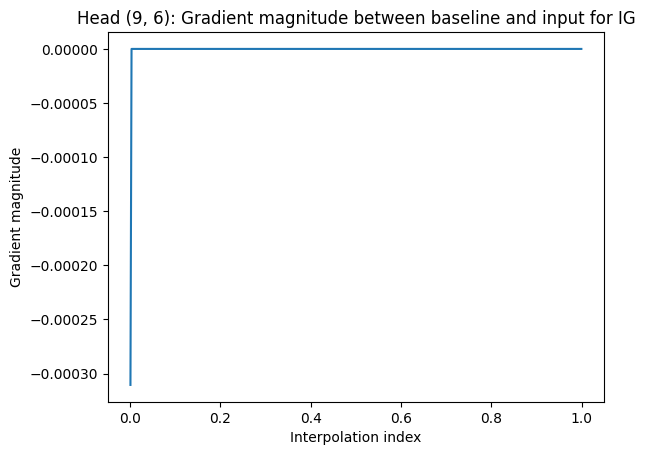

tensor([-0.0003,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000])
Interpolation turning point: tensor([0])


In [ ]:
# Gradient magnitude for head exclusively highlighted by IG as important

visualise_attn_grad_attribution(9, 6)

Running attribution!
Attribution score for head (7, 3): tensor([-1.5179e-06])
Matches previous IG score:  [ True]


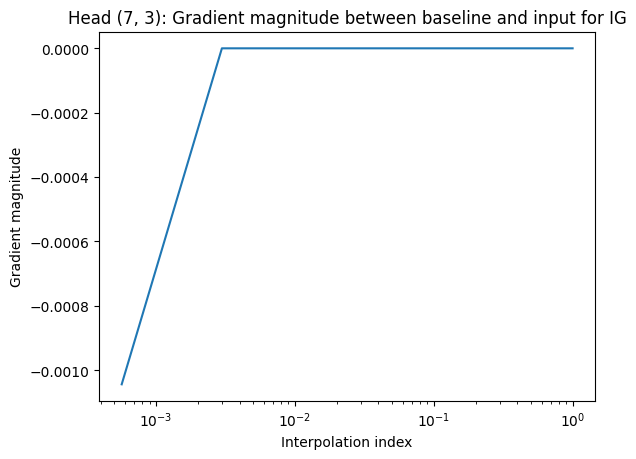

tensor([-0.0010,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000])
Interpolation turning point: tensor([0])
Running attribution!
Attribution score for head (10, 7): tensor([3.8402e-06])
Matches previous IG score:  [ True]


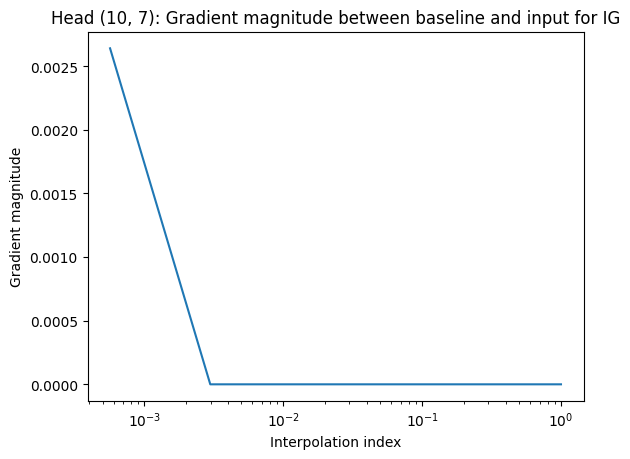

tensor([0.0026, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
Interpolation turning point: tensor([0])


In [ ]:
# Gradient magnitude for attention heads highlighted by both methods

visualise_attn_grad_attribution(7, 3)
visualise_attn_grad_attribution(10, 7)

Running attribution!
Attribution score for head (1, 7): tensor([-2.0696e-08])
Matches previous IG score:  [ True]


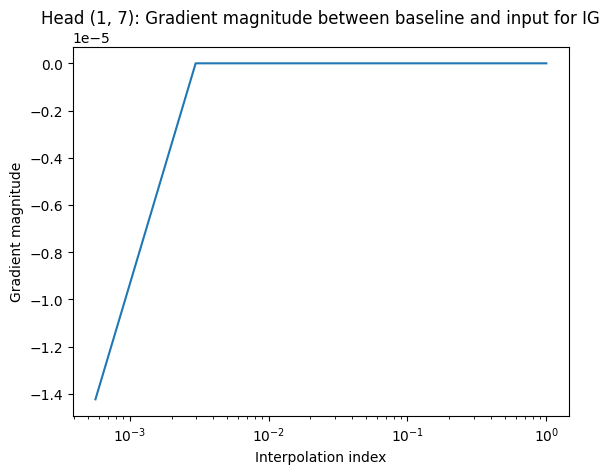

In [ ]:
# Attention head with very low attribution scores in both methods

visualise_attn_grad_attribution(1, 7)

For all attention heads, the gradient magnitude seems to increase or decrease sharply (until the 9th interpolation step) then plateau at 0. The magnitude of the attribution score depends on the size of the range in gradient magnitudes.

* Possibly the sharp corner point is the minimal contrastive example for which these attention heads light up? Motivation to find optimal contrastive baseline/input pair to obtain the same or greater attribution scores, as a way to identify behaviour.
    * Note that even though all the turning points are at the same interpolation index, this does not necessarily mean that they all have the same optimal counterfactual pairing, because we are interpolating along different activations for each attention head.
    * Can we reverse engineer the activations based on this interpolation point?
* Doesn't explain why IG highlights some attention heads which ablation does not highlight

### Visualising outputs

Here, we visualise the outputs with respect to interpolated layer inputs to see how the shape of the output curves might change when attribution scores are different.

In [162]:
from captum.attr._utils.approximation_methods import approximation_parameters

def visualise_attn_interpolated_outputs(target_layer_num, target_pos):
    hook_name = get_act_name("result", target_layer_num)
    target_layer = model.hook_dict[hook_name]

    layer_clean_input = clean_cache[hook_name] # Baseline

    # Only corrupt at target head
    layer_corrupt_input = layer_clean_input.clone()
    layer_corrupt_input[:, :, target_pos] = corrupted_cache[hook_name][:, :, target_pos]

    # Take the model starting from the target layer
    forward_fn = lambda x: run_from_layer_fn(x, clean_input, target_layer)
    _, alphas_func = approximation_parameters("gausslegendre")
    alphas = alphas_func(n_steps)

    with torch.autograd.set_grad_enabled(True):
        interpolated_inputs = [layer_clean_input + alpha * (layer_corrupt_input - layer_clean_input) for alpha in alphas]
        outputs = [forward_fn(i) for i in interpolated_inputs]

    print(outputs)

    plt.title(f"Model output at interpolated gradients: head {(target_layer_num, target_pos)}")
    plt.plot([o.item() for o in outputs])
    plt.xlabel("Interpolation coefficient")
    plt.ylabel("Output (logit difference)")
    plt.ylim(0, 6)
    plt.show()

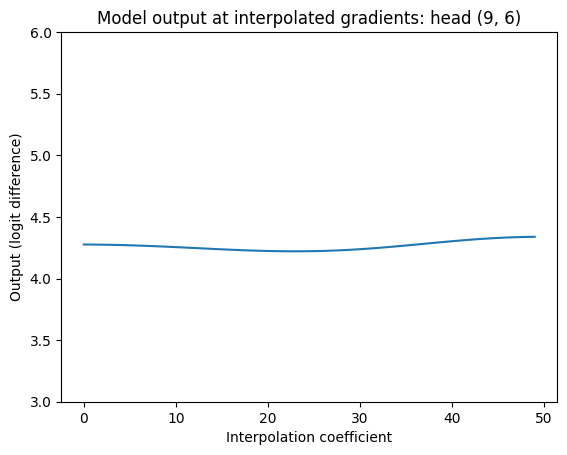

In [98]:
# Highlighted only by IG

visualise_attn_interpolated_outputs(9, 6)

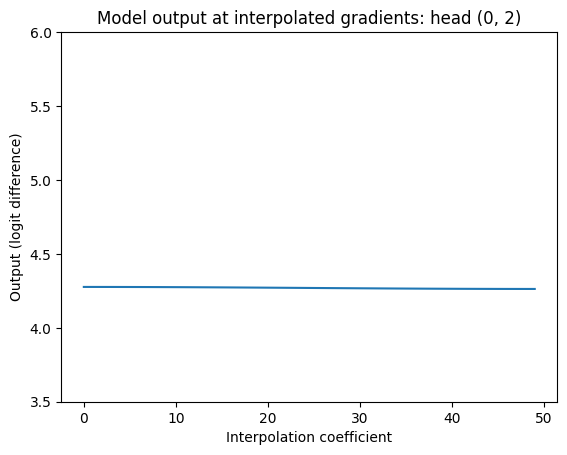

In [28]:
visualise_attn_interpolated_outputs(0, 2)

The attention head for which only integrated gradients highlights (weakly) has a very low gradient, i.e. the outputs do not change significantly when the input is interpolated. This is in contrast to other attention heads which have stronger attribution scores in both methods; these methods have larger gradients. The change in gradients is still larger than attention heads which have negligible attribution scores (these have flat output gradients).

It may just be that IG is more error-prone as it over-estimates the importance of components for which outputs fluctuate slightly.

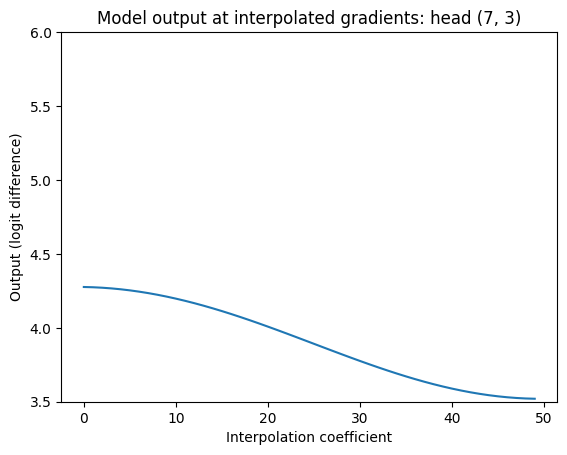

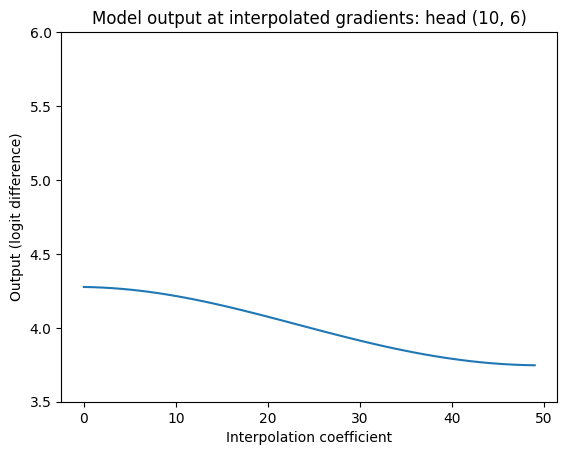

In [ ]:
# Highlighted by both, strong impact on performance under ablation

visualise_attn_interpolated_outputs(7, 3)
visualise_attn_interpolated_outputs(10, 6)

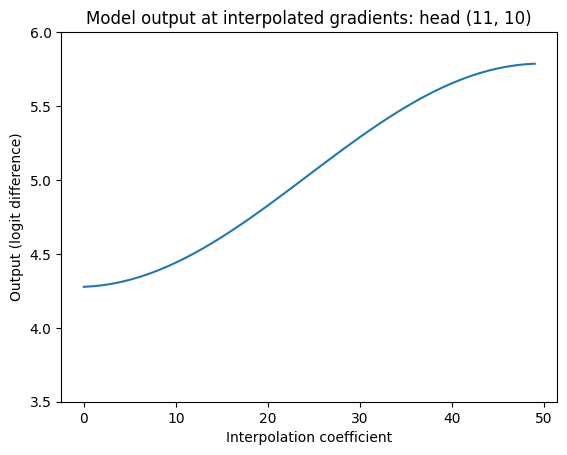

In [ ]:
# Highlighted by both, positive effect on performance under ablation

visualise_attn_interpolated_outputs(11, 10)

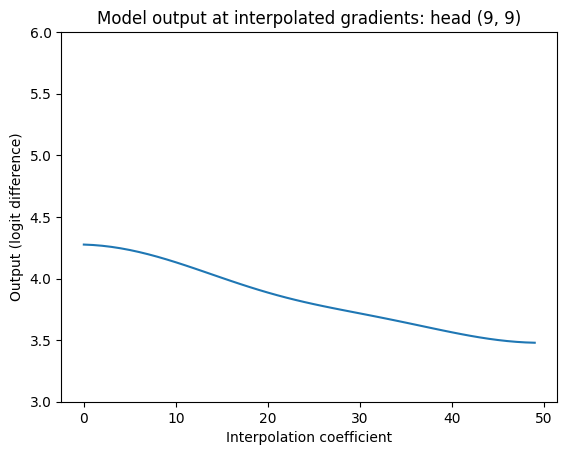

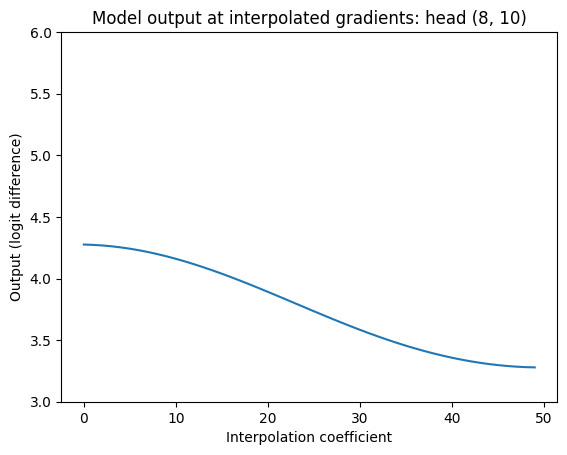

In [99]:
# Highlighted in both methods, lack of ablation effect

visualise_attn_interpolated_outputs(9, 9)
visualise_attn_interpolated_outputs(8, 10)

[tensor([4.2764], grad_fn=<UnsqueezeBackward0>), tensor([4.2765], grad_fn=<UnsqueezeBackward0>), tensor([4.2765], grad_fn=<UnsqueezeBackward0>), tensor([4.2766], grad_fn=<UnsqueezeBackward0>), tensor([4.2766], grad_fn=<UnsqueezeBackward0>), tensor([4.2767], grad_fn=<UnsqueezeBackward0>), tensor([4.2768], grad_fn=<UnsqueezeBackward0>), tensor([4.2770], grad_fn=<UnsqueezeBackward0>), tensor([4.2771], grad_fn=<UnsqueezeBackward0>), tensor([4.2772], grad_fn=<UnsqueezeBackward0>), tensor([4.2774], grad_fn=<UnsqueezeBackward0>), tensor([4.2776], grad_fn=<UnsqueezeBackward0>), tensor([4.2778], grad_fn=<UnsqueezeBackward0>), tensor([4.2780], grad_fn=<UnsqueezeBackward0>), tensor([4.2782], grad_fn=<UnsqueezeBackward0>), tensor([4.2784], grad_fn=<UnsqueezeBackward0>), tensor([4.2787], grad_fn=<UnsqueezeBackward0>), tensor([4.2789], grad_fn=<UnsqueezeBackward0>), tensor([4.2792], grad_fn=<UnsqueezeBackward0>), tensor([4.2795], grad_fn=<UnsqueezeBackward0>), tensor([4.2797], grad_fn=<UnsqueezeBack

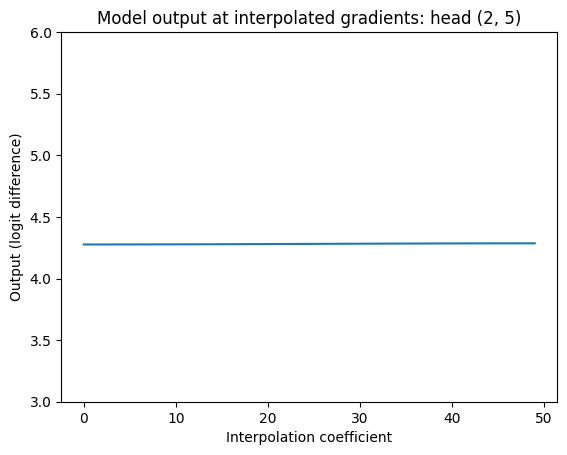

[tensor([4.2764], grad_fn=<UnsqueezeBackward0>), tensor([4.2764], grad_fn=<UnsqueezeBackward0>), tensor([4.2763], grad_fn=<UnsqueezeBackward0>), tensor([4.2762], grad_fn=<UnsqueezeBackward0>), tensor([4.2760], grad_fn=<UnsqueezeBackward0>), tensor([4.2758], grad_fn=<UnsqueezeBackward0>), tensor([4.2756], grad_fn=<UnsqueezeBackward0>), tensor([4.2754], grad_fn=<UnsqueezeBackward0>), tensor([4.2751], grad_fn=<UnsqueezeBackward0>), tensor([4.2748], grad_fn=<UnsqueezeBackward0>), tensor([4.2744], grad_fn=<UnsqueezeBackward0>), tensor([4.2741], grad_fn=<UnsqueezeBackward0>), tensor([4.2737], grad_fn=<UnsqueezeBackward0>), tensor([4.2732], grad_fn=<UnsqueezeBackward0>), tensor([4.2728], grad_fn=<UnsqueezeBackward0>), tensor([4.2723], grad_fn=<UnsqueezeBackward0>), tensor([4.2718], grad_fn=<UnsqueezeBackward0>), tensor([4.2713], grad_fn=<UnsqueezeBackward0>), tensor([4.2708], grad_fn=<UnsqueezeBackward0>), tensor([4.2703], grad_fn=<UnsqueezeBackward0>), tensor([4.2697], grad_fn=<UnsqueezeBack

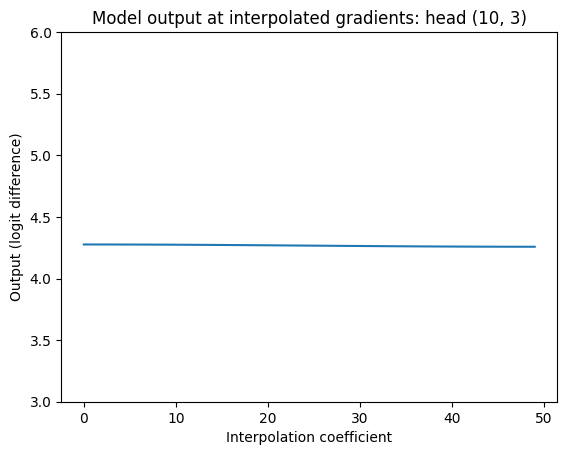

In [160]:
# Low attribution scores in both methods

visualise_attn_interpolated_outputs(2, 5)
visualise_attn_interpolated_outputs(10, 3)

So the attention heads with the attribution scores tend to have peaks and troughs at the input counterfactual and baseline counterfactual respectively. This begs the question - can we visualise how the output changes over a much wider range of interpolation? Are there peaks and troughs outside of this range for the other attention heads, for which IG would higlight given the optimal counterfactual pairs?

* IDEA: identify the peaks and troughs for the outputs wrt a specific component. Fix the baseline; vary the activation of the specific component up to a different input and check the outputs.

### Alternative implementation [IGNORE]

In [ ]:
from captum.attr._utils.common import _format_input_baseline, _tensorize_baseline
from captum.attr._utils.approximation_methods import approximation_parameters
import torch
import numpy as np

def attribute_with_gradients(forward_func, layer, inputs, baselines=None, target=None, n_steps=50):
    # Format inputs and baselines
    inps, baselines = _format_input_baseline(inputs, baselines)
    baselines = _tensorize_baseline(inps, baselines)

    # Generate alphas (interpolation coefficients)
    step_sizes_func, alphas_func = approximation_parameters("gausslegendre")
    step_sizes, alphas = step_sizes_func(n_steps), alphas_func(n_steps)

    # Unwrap tuple
    inps, baselines = inps[0], baselines[0]

    # Store gradients at each step
    gradient_history = torch.zeros((n_steps,) + inps.shape[1:])

    # interpolated_inputs = torch.cat([baselines + alpha * (inps - baselines) for alpha in alphas], dim=0).requires_grad_()

    # with torch.autograd.set_grad_enabled(True):
    #     output = forward_func(interpolated_inputs)
    #     gradient_history = torch.autograd.grad(output, interpolated_inputs)[0]

    for i, alpha in enumerate(alphas):
        # Interpolate between baseline and input
        interpolated_input = baselines + alpha * (inps - baselines)

        # Forward pass
        with torch.autograd.set_grad_enabled(True):
            model.reset_hooks()
            output = forward_func(interpolated_input)
            # Compute gradients
            gradients = torch.autograd.grad(output, interpolated_input)[0]
            gradient_history[i] = gradients
            model.reset_hooks()

    # Accumulate gradients (Riemann sum)
    scaled_grads = gradient_history.contiguous().view(n_steps, -1) * torch.tensor(step_sizes).float().view(n_steps, 1).to(gradient_history.device)
    scaled_grads = scaled_grads.reshape(gradient_history.shape)
    acc_gradients = gradient_history.sum(dim=0)

    # Scale average gradients by the input difference
    integrated_gradients = (inps - baselines) * acc_gradients.to(inps.device)

    return integrated_gradients, gradient_history, alphas

In [105]:
torch.set_grad_enabled(True)

# Calculate attribution score based on mean over each embedding, for each token
def mean_attribution(attribution_scores, pos=None):
    per_token_score = attribution_scores.mean(dim=3)
    score = per_token_score.mean(dim=1)
    if pos is None:
        return score
    return score[:, pos]

def attn_gradient_attribution_history(target_layer_num, target_pos):
    hook_name = get_act_name("result", target_layer_num)
    target_layer = model.hook_dict[hook_name]
    prev_layer_hook = get_act_name("z", target_layer_num)
    prev_layer = model.hook_dict[prev_layer_hook]

    layer_clean_input = clean_cache[prev_layer_hook]
    layer_corrupt_input = corrupted_cache[prev_layer_hook]

    layer_clean_input.requires_grad = False
    layer_corrupt_input.requires_grad = False

    forward_fn = lambda x: run_from_layer_fn(x, clean_input, prev_layer, reset_hooks_end=False)
    attributions, gradient_history, alphas = attribute_with_gradients(forward_fn, target_layer, inputs=layer_corrupt_input, baselines=layer_clean_input)

    print(gradient_history.shape)

    model.reset_hooks()

    target_result = mean_attribution(attributions, pos=target_pos)
    mean_gradient_history = mean_attribution(gradient_history, pos=target_pos)

    return target_result, mean_gradient_history, alphas

torch.Size([50, 17, 12, 64])
Attribution score for head (9, 6): tensor([-0.0075], device='mps:0')
Original attribution score: -4.5159794126448105e-07


/var/folders/p_/zl8q73md4vgb11fc063_516h0000gn/T/ipykernel_3805/1858058142.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


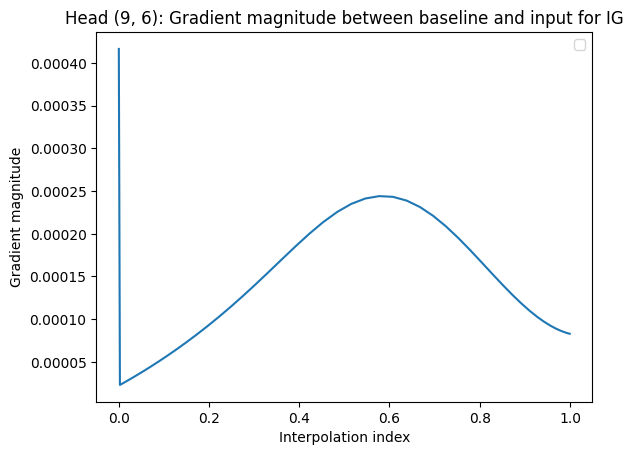

In [106]:
# Gradient attribution on target head (9, 6)
head_96_result, head_96_gradient_history, alphas = attn_gradient_attribution_history(9, 6)

print(f"Attribution score for head (9, 6): {head_96_result}")

print(f"Original attribution score: {attn_ig_results[9, 6]}")

plt.title("Head (9, 6): Gradient magnitude between baseline and input for IG")
plt.plot(alphas, head_96_gradient_history.detach().cpu())
plt.xlabel("Interpolation index")
plt.ylabel("Gradient magnitude")
plt.legend()
plt.show()

It looks like the attention head (9, 6) has a non-monotonically increasing gradient. This could explain why ablating this head does not affect performance too much, even though it has a high attribution score (integral).

tensor([[[[[ 1.7618e-02,  4.1763e-02,  5.9976e-04,  ...,  2.9827e-02,
            -3.5117e-02,  4.2089e-03],
           [ 2.9813e-02,  3.3549e-02, -3.2090e-02,  ..., -7.2364e-02,
             7.8541e-02, -5.8421e-02],
           [-3.4735e-02, -1.6777e-02,  1.7707e-03,  ...,  4.3039e-02,
            -8.7528e-03,  1.3601e-02],
           ...,
           [ 1.9519e-02,  1.1197e-02, -2.3995e-02,  ...,  3.5203e-02,
             2.6373e-02,  2.0359e-02],
           [-2.4930e-02, -1.3157e-02,  1.8961e-02,  ...,  4.7290e-02,
            -2.8947e-03,  1.8361e-02],
           [-5.9239e-02, -3.5429e-02, -4.3080e-02,  ...,  5.6197e-02,
             4.4464e-03,  1.3412e-02]],

          [[-1.8948e-02, -1.7704e-02, -5.2698e-04,  ...,  2.0462e-02,
             4.6606e-02,  3.2864e-02],
           [-2.7703e-02,  5.9852e-03, -1.3731e-01,  ..., -7.0407e-02,
            -2.3632e-02,  1.8006e-02],
           [-1.2885e-02, -2.4630e-02, -2.6925e-02,  ..., -2.2712e-02,
            -1.3910e-02,  6.1605e-02],
 

/var/folders/p_/zl8q73md4vgb11fc063_516h0000gn/T/ipykernel_3805/2506077647.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


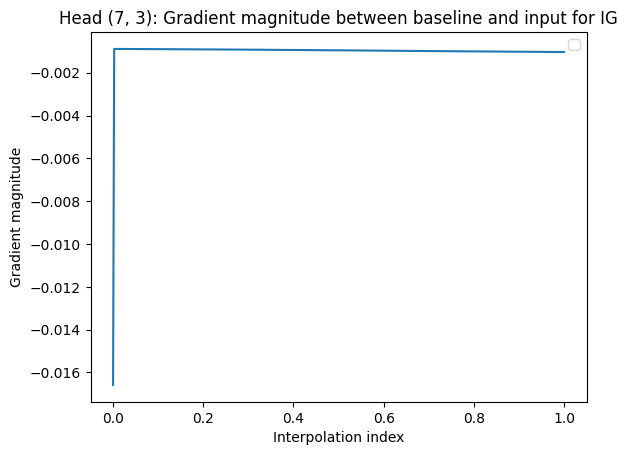

In [47]:
head_73_result, head_73_gradient_history, alphas = attn_gradient_attribution_history(7, 3)

print(f"Attribution score for head (7, 3): {head_73_result}")

plt.title("Head (7, 3): Gradient magnitude between baseline and input for IG")
plt.plot(alphas, head_73_gradient_history)
plt.xlabel("Interpolation index")
plt.ylabel("Gradient magnitude")
plt.legend()
plt.show()

## "Optimal" contrastive pairs

Consider head (9, 6), which according to the IOI paper is a name mover head:

"Name Mover Heads output the remaining name. They are active at END, attend to previous names in the sentence, and copy the names they attend to".

We use a different contrastive pair related to the IOI task, to try and get a high attribution score under IG. We change the corrupted prompt such that 1) the output should change from "John" to "Mary", and 2) the name copying head (hypothesised role of head 9.6) is even more important.

In [163]:
#| output: true

clean_prompt = "After John and Mary went to the store, Mary gave a bottle of milk to"
corrupted_prompt = "After the cat and the dog went to the store, Mary gave a bottle of milk to"

clean_input, corrupted_input = model.to_tokens([clean_prompt, corrupted_prompt])

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

clean_logits, clean_cache = model.run_with_cache(clean_input)
clean_logit_diff = logits_to_logit_diff(clean_logits)
print(f"Clean logit difference: {clean_logit_diff.item():.3f}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_input)
corrupted_logit_diff = logits_to_logit_diff(corrupted_logits)
print(f"Corrupted logit difference: {corrupted_logit_diff.item():.3f}")

Clean logit difference: 1.458
Corrupted logit difference: -0.274


In [164]:
# Gradient attribution on heads
hook_name = get_act_name("result", 9)
target_layer = model.hook_dict[hook_name]
prev_layer_hook = get_act_name("z", 9)
prev_layer = model.hook_dict[prev_layer_hook]

layer_clean_input = clean_cache[prev_layer_hook]
layer_corrupt_input = corrupted_cache[prev_layer_hook]

attributions = compute_layer_to_output_attributions(clean_input, layer_clean_input, layer_corrupt_input, target_layer, prev_layer) # shape [1, seq_len, d_head, d_model]
# Calculate attribution score based on mean over each embedding, for each token
per_token_score = attributions.mean(dim=3)
score = per_token_score.mean(dim=1)

print(score[:,6])


Error (delta) for blocks.9.attn.hook_result attribution: -0.9106521606445312
tensor([3.3620e-08])


In [112]:
# Original scores

print(attn_ig_results[9, 6])
print(attn_patch_results[9, 6])

tensor(-4.5160e-07)
tensor(0.0089)


[tensor([1.4576], grad_fn=<UnsqueezeBackward0>), tensor([1.4568], grad_fn=<UnsqueezeBackward0>), tensor([1.4553], grad_fn=<UnsqueezeBackward0>), tensor([1.4532], grad_fn=<UnsqueezeBackward0>), tensor([1.4504], grad_fn=<UnsqueezeBackward0>), tensor([1.4471], grad_fn=<UnsqueezeBackward0>), tensor([1.4431], grad_fn=<UnsqueezeBackward0>), tensor([1.4385], grad_fn=<UnsqueezeBackward0>), tensor([1.4333], grad_fn=<UnsqueezeBackward0>), tensor([1.4276], grad_fn=<UnsqueezeBackward0>), tensor([1.4213], grad_fn=<UnsqueezeBackward0>), tensor([1.4146], grad_fn=<UnsqueezeBackward0>), tensor([1.4073], grad_fn=<UnsqueezeBackward0>), tensor([1.3996], grad_fn=<UnsqueezeBackward0>), tensor([1.3914], grad_fn=<UnsqueezeBackward0>), tensor([1.3828], grad_fn=<UnsqueezeBackward0>), tensor([1.3739], grad_fn=<UnsqueezeBackward0>), tensor([1.3646], grad_fn=<UnsqueezeBackward0>), tensor([1.3551], grad_fn=<UnsqueezeBackward0>), tensor([1.3453], grad_fn=<UnsqueezeBackward0>), tensor([1.3352], grad_fn=<UnsqueezeBack

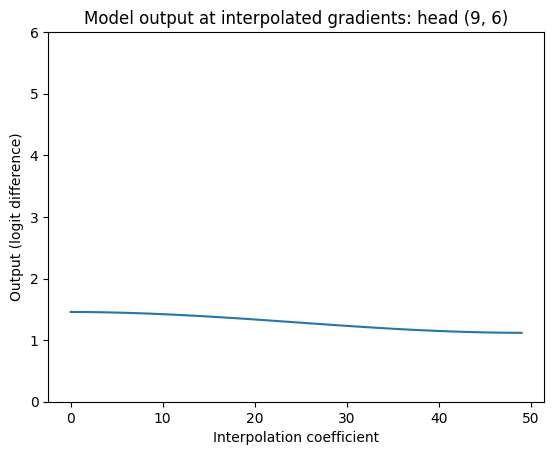

In [165]:
visualise_attn_interpolated_outputs(9, 6)

In [166]:
# Get activation patching scores

hook_name = get_act_name("result", 9)
temp_hook = lambda act, hook: patch_attn_hook(act, hook, corrupted_cache, 6)

with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
    patched_logits = model(clean_input)

patched_logit_diff = logits_to_logit_diff(patched_logits).detach()
# Normalise result by clean and corrupted logit difference
ap_score = (patched_logit_diff - clean_logit_diff) / baseline_diff
print(ap_score)

tensor(-0.0456)


Changing the baseline inputs such that the output gradients vary more doesn't necessarily seem to affect IG too much, but it does increase the magnitude of the activation patching score.

It seems clear that the baselines used for attribution methods are extremely important hyper-parameters, but there is no clear intuition as to which baseline is "best" for evaluating specific model behaviours. This provides motivation for a new method which identifies the optimal counterfactuals to make attribution methods highlight specific components.